# PUC Minas – Pontificia Universidade Católica de Minas Gerais
## Pós-Graduação em Ciência de Dados e Big Data
### TRABALHO DE CONCLUSÃO DE CURSO
#### **CARACTERIZAÇÃO E PREDIÇÃO COM TÉCNICAS DE *MACHINE LEARNING* DA MORTALIDADE INFANTIL NO ESTADO DO RIO DE JANEIRO**

* **Aluna: Roberta Gomes de Souza Netto**
* **Matrícula: 1145666**
------

## 1. Introdução
### 1.1 Contextualização
A mortalidade infantil é considerada um dos principais problemas sociais no mundo. A situação no Brasil é considerada um problema de saúde pública e sua redução é ainda um desafio para os serviços de saúde e a sociedade como um todo. Apesar do declínio que vem sendo observado nos últimos anos, a velocidade de queda está aquém do desejado e tem colocado os pesquisadores cada vez mais dedicados aos estudos das informações relacionadas, procurando identificar grupos de maior risco, que demandam atenção diferenciada. 
### 1.2 O problema proposto
Mesmo que o Brasil apresente um declínio significativo nos números apresentados, tanto na esfera federal, como na estadual e municipal, continuam ocorrendo mortes por fatores que são passíveis de serem solucionados.

Além da caracterização dos casos de óbito, é indispensável um estudo preditivo de forma a identificar o desvio das realizações, que quando abaixo do previsto, pode mostrar a eficiência das ações implementadas.
### 1.3 Objetivos
Esse estudo tem como objetivo a caracterização dos fatores de risco de óbito infantil no estado do Rio de Janeiro, a identificação dos aspectos mais relevantes que influenciam sua ocorrência e a análise de algoritmos de predição para criar modelos que sejam capazes de prever a Taxa de Mortalidade Infantil. 

De forma prática, o objetivo desse projeto é responder as seguintes questões:
- Quais os fatores de risco de óbito infantil no estado do Rio de Janeiro? 
- Qual modelo de predição é mais assertivo para o acompanhamento da taxa de mortalidade futura?

## 2. Coleta de Dados
### 2.1 Extração dos Dados e Geração dos Arquivos .csv
Devido a base original ser muito grande, esta etapa foi realizada em um notebook separado, gerando ao final da consulta 3 arquivos no formato .csv contendo os dados completos.

- sim_rj_2016-2020.csv - **Fonte:** *https://basedosdados.org/dataset/br-ms-sim?bdm_table=microdados*
- sinasc_rj_2016-2020.csv - **Fonte:** *https://basedosdados.org/dataset/br-ms-sinasc?bdm_table=microdados*
- cid10_original.csv - **Fonte:** *https://basedosdados.org/dataset/br-bd-diretorios-brasil?bdm_table=cid_10*

***Extração realizada em 23 de março 2023.***  

Como o processo é demorado, foi rodado uma única vez e ao longo do estudo passaram a ser utilizados os arquivos gerados.

### 2.2 Importação das Bibliotecas Utilizadas


In [1]:
import pandas as pd # manipulação de bases de dados
import numpy as np # processamento numérico
import matplotlib.pyplot as plt # visualização de dados
import seaborn as sns # visualização de dados

from textwrap import wrap # quebra de linha no texto no eixo do gráfico
from statsmodels.tsa.seasonal import seasonal_decompose # decomposição da série
from statsmodels.tsa.stattools import adfuller # teste Dickey-Fuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Autocorrelação Total e Parcial

# Não exibir os warnings
import warnings
warnings.filterwarnings('ignore')

# Modelos
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.tree import DecisionTreeRegressor 

# Metricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

### 2.3 Importação dos Dados

In [2]:
df_sim = pd.read_csv('sim_rj_2016-2020.csv', sep=',')
df_sinasc = pd.read_csv('sinasc_rj_2016-2020.csv', sep=',')
df_cid10 = pd.read_csv('cid10_original.csv', sep=',')

In [3]:
print("\nDimensões df_sim:\n{0}\n".format(df_sim.shape))
print("\nDimensões df_sinasc:\n{0}\n".format(df_sinasc.shape))
print("\nDimensões df_cid10:\n{0}\n".format(df_cid10.shape))


Dimensões df_sim:
(735289, 93)


Dimensões df_sinasc:
(1069911, 67)


Dimensões df_cid10:
(12451, 9)



- **Descrição dos Dados Coletados**

In [4]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735289 entries, 0 to 735288
Data columns (total 93 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      735289 non-null  int64  
 1   ano                             735289 non-null  int64  
 2   sigla_uf                        735289 non-null  object 
 3   sequencial_obito                735289 non-null  int64  
 4   tipo_obito                      735289 non-null  int64  
 5   causa_basica                    735289 non-null  object 
 6   data_obito                      735289 non-null  object 
 7   hora_obito                      691451 non-null  object 
 8   naturalidade                    546548 non-null  float64
 9   data_nascimento                 730431 non-null  object 
 10  idade                           730021 non-null  float64
 11  sexo                            735289 non-null  int64  
 12  raca_cor        

In [5]:
df_sinasc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069911 entries, 0 to 1069910
Data columns (total 67 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   Unnamed: 0                         1069911 non-null  int64  
 1   ano                                1069911 non-null  int64  
 2   sigla_uf                           1069911 non-null  object 
 3   sequencial_nascimento              1069911 non-null  int64  
 4   id_municipio_nascimento            1069907 non-null  float64
 5   local_nascimento                   1069911 non-null  int64  
 6   codigo_estabelecimento             1064091 non-null  float64
 7   data_nascimento                    1069911 non-null  object 
 8   hora_nascimento                    1068996 non-null  object 
 9   sexo                               1069911 non-null  int64  
 10  peso                               1069887 non-null  float64
 11  raca_cor                

**Nota:
Como os dois datasets acima possuem muitas colunas, sendo a maioria descartada posteriormente, a descrição das colunas originais está apenas no documento pdf do trabalho. Adiante é apresentada a descrição das colunas de interesse.** 

In [6]:
df_cid10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12451 entries, 0 to 12450
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              12451 non-null  int64 
 1   subcategoria            12451 non-null  object
 2   descricao_subcategoria  12451 non-null  object
 3   categoria               12451 non-null  object
 4   descricao_categoria     12451 non-null  object
 5   capitulo                12451 non-null  object
 6   descricao_capitulo      12451 non-null  object
 7   causa_violencia         12451 non-null  int64 
 8   causa_overdose          12451 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 875.6+ KB


**Colunas:**

- **subcategoria:** Subcategoria da CID-10.
- **descricao_subcategoria:** Descrição da Subcategoria da CID-10.
- **categoria:** Categoria da CID-10.
- **descricao_categoria:** Descrição da Categoria da CID-10.
- **capitulo:** Capítulo da CID-10.
- **descricao_capitulo:** Descrição do Capítulo da CID-10.
- **causa_violencia:** Causa - Violência (0 = Não, 1 = Sim).
- **causa_overdose:** Causa - Overdose (0 = Não, 1 = Sim).

## 3. Processamento/Tratamento de Dados
### 3.1 Seleção dos dados de interesse

In [7]:
# Selecionando colunas de interesse
df_sim = df_sim.drop(columns=['Unnamed: 0','sigla_uf','sequencial_obito','tipo_obito','hora_obito','naturalidade',
                              'estado_civil','escolaridade','ocupacao','codigo_bairro_residencia','id_municipio_residencia',
                              'codigo_bairro_ocorrencia','id_municipio_ocorrencia','escolaridade_mae','ocupacao_mae',
                              'quantidade_filhos_vivos','quantidade_filhos_mortos','obito_gravidez','obito_puerperio',
                              'assistencia_medica','exame','cirurgia','necropsia','linha_a','linha_b','linha_c','linha_d',
                              'linha_ii','circunstancia_obito','acidente_trabalho','fonte','codigo_estabelecimento','atestante',
                              'data_atestado','tipo_pos','data_investigacao','data_cadastro','fonte_investigacao',
                              'data_recebimento','causa_basica_pre','tipo_obito_ocorrencia','tipo_morte_ocorrencia',
                              'data_cadastro_informacao','data_cadastro_investigacao','id_municipio_svo_iml',
                              'data_recebimento_original','data_recebimento_original_a','causa_materna','status_do_epidem',
                              'status_do_nova','serie_escolar_falecido','serie_escolar_mae','escolaridade_2010',
                              'escolaridade_falecido_2010_agr','escolaridade_mae_2010_agr','semanas_gestacao','diferenca_data',
                              'data_conclusao_investigacao','data_conclusao_caso','numero_dias_obito_investigacao',
                              'id_municipio_naturalidade','descricao_estabelecimento','crm','numero_lote','status_codificadora',
                              'codificado','versao_sistema','versao_scb','atestado','numero_dias_obito_ficha','fontes',
                              'tipo_resgate_informacao','tipo_nivel_investigador','numero_dias_informacao','fontes_informacao',
                              'alt_causa'])
print("\nDimensões:\n{0}\n".format(df_sim.shape))


Dimensões:
(735289, 17)



**Colunas de interesse:**

- **ano:** Ano de ocorrência do óbito.
- **causa_basica:** Causa básica final - determinada após a investigação do óbito (Código CID-10).
- **data_obito:** Data de ocorrência do óbito.
- **data_nascimento:** Data de nascimento.
- **idade:** Idade do falecido.
- **sexo:** Sexo do falecido. 1 : Masculino, 2 : Feminino, 9 : Ignorado (selecionado em casos especiais em que não foi possível definir o sexo).
- **raca_cor:** Raça/Cor do falecido. 1 : Branca, 2 : Preta, 3 : Amarela, 4 : Parda, 5 : Indígena.
- **local_ocorrencia:** Local de ocorrência do óbito. 1 : Hospital, 2 : Outro estabelecimento de saúde, 3 : Domicílio, 4 : Via pública, 5 : Outros.
- **idade_mae:** Idade da mãe na ocorrência do óbito, em anos.
- **gravidez:** Tipo de gravidez. 1 : Única, 2 : Dupla, 3 : Tripla ou mais
- **gestacao:** Faixas de semanas de gestação. 1 : Menos de 22 semanas, 2 : 22 a 27 semanas, 3 : 28 a 31 semanas, 4 : 32 a 36 semanas, 5 : 37 a 41 semanas, 6 : 42 semanas ou mais
- **parto:** Tipo de parto. 1 : Vaginal, 2 : Cesáreo
- **obito_parto:** Momento do óbito em relação ao parto. 1 : Antes, 2 : Durante, 3 : Depois
- **morte_parto:** Momento do óbito em relação ao parto. 1 : Antes, 2 : Durante, 3 : Depois
- **peso:** Peso do falecido em gramas.
- **causa_basica_original:** Causa básica registrada no momento do óbito (Código CID-10).
- **escolaridade_mae_2010:** Escolaridade da mãe na ocorrência do óbito. 0 : Sem escolaridade, 1 : Fundamental I, 2 : Fundamental II, 3 : Médio, 4 : Superior incompleto, 5 : Superior completo.

In [8]:
# Selecionando colunas de interesse
df_sinasc = df_sinasc.drop(columns=['Unnamed: 0','sigla_uf','sequencial_nascimento','id_municipio_nascimento',
                                    'codigo_estabelecimento','hora_nascimento','apgar1','apgar5','id_anomalia',
                                    'semana_gestacao','semana_gestacao_estimada','inicio_pre_natal','pre_natal',
                                    'pre_natal_agr','classificacao_pre_natal','quantidade_filhos_vivos',
                                    'quantidade_filhos_mortos','id_pais_mae','id_uf_mae','id_municipio_mae',
                                    'id_pais_residencia','id_municipio_residencia','data_nascimento_mae','escolaridade_mae',
                                    'serie_escolar_mae','escolaridade_2010_agr_mae','estado_civil_mae','ocupacao_mae',
                                    'raca_cor_mae','gestacoes_ant','quantidade_parto_normal','quantidade_parto_cesareo',
                                    'data_ultima_menstruacao','tipo_apresentacao','inducao_parto','cesarea_antes_parto',
                                    'tipo_robson','idade_pai','cartorio','registro_cartorio','data_registro_cartorio','origem',
                                    'numero_lote','versao_sistema','data_cadastro','data_recebimento',
                                    'data_recebimento_original','diferenca_data','data_declaracao','funcao_responsavel',
                                    'documento_responsavel','formacao_profissional_responsavel','status_dn','status_dn_nova',
                                    'paridade'])
print("\nDimensões:\n{0}\n".format(df_sinasc.shape))


Dimensões:
(1069911, 12)



**Colunas de interesse:**
		
- **ano:** Ano de nascimento.
- **local_ocorrencia:** Local de nascimento. 1 : Hospital, 2 : Outro estabelecimento de saúde, 3 : Domicílio, 4 : Outros, 5 : Aldeia Indígena.
- **data_nascimento:** Data de nascimento.
- **sexo:** Sexo da criança. 1 : Masculino, 2 : Feminino, 9 : Ignorado (selecionado em casos especiais em que não foi possível definir o sexo).
- **peso:** Peso da criança em gramas.
- **raca_cor:** Raça/Cor da criança. 1 : Branca, 2 : Preta, 3 : Amarela, 4 : Parda, 5 : Indígena.
- **codigo_anomalia:** Anomalia (Código CID-10).
- **gestacao_agr:** Faixas de semanas de gestação. 1 : Menos de 22 semanas, 2 : 22 a 27 semanas, 3 : 28 a 31 semanas, 4 : 32 a 36 semanas, 5 : 37 a 41 semanas, 6 : 42 semanas ou mais
- **tipo_gravidez:** Tipo de gravidez. 1 : Única, 2 : Dupla, 3 : Tripla ou mais
- **tipo_parto:** Tipo de parto. 1 : Vaginal, 2 : Cesáreo
- **idade_mae:** Idade da mãe no momento do nascimento em anos.
- **escolaridade_2010_mae:** Escolaridade da mãe no momento do nascimento. 0 : Sem escolaridade, 1 : Fundamental I, 2 : Fundamental II, 3 : Médio, 4 : Superior incompleto, 5 : Superior completo.

In [9]:
# Selecionando colunas de interesse
df_cid10 = df_cid10.drop(columns=['Unnamed: 0','descricao_subcategoria','categoria','descricao_categoria','capitulo',
                                  'causa_violencia','causa_overdose'])
print("\nDimensões:\n{0}\n".format(df_cid10.shape))


Dimensões:
(12451, 2)



**Colunas de interesse:**
		
- **subcategoria:** Código da causa e/ou anomalia (Código CID-10).
- **descricao_capitulo:** Descrição macro da causa e/ou anomalia.

### **Filtrando os registros de óbitos**

Para mortalidade infantil são considerados os óbitos até o primeiro ano de vida e ocorridos depois do parto.

Como o atributo "idade" possui valores estranhos, decidiu-se por utilizar os atributos "data_obito" e "data_nascimento" para o cálculo da idade.

In [10]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735289 entries, 0 to 735288
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ano                    735289 non-null  int64  
 1   causa_basica           735289 non-null  object 
 2   data_obito             735289 non-null  object 
 3   data_nascimento        730431 non-null  object 
 4   idade                  730021 non-null  float64
 5   sexo                   735289 non-null  int64  
 6   raca_cor               727715 non-null  float64
 7   local_ocorrencia       735289 non-null  int64  
 8   idade_mae              12665 non-null   float64
 9   gravidez               13037 non-null   float64
 10  gestacao               12429 non-null   float64
 11  parto                  12917 non-null   float64
 12  obito_parto            12726 non-null   float64
 13  morte_parto            10862 non-null   float64
 14  peso                   12713 non-nul

Os atributos "data_obito" e "data_nascimento" estão com Dtype "object". Para realizar o cálculo é necessário transformá-las para o tipo datetime.

In [11]:
df_sim["data_obito"] = pd.to_datetime(df_sim["data_obito"])
df_sim["data_nascimento"] = pd.to_datetime(df_sim["data_nascimento"])

In [12]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735289 entries, 0 to 735288
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ano                    735289 non-null  int64         
 1   causa_basica           735289 non-null  object        
 2   data_obito             735289 non-null  datetime64[ns]
 3   data_nascimento        730431 non-null  datetime64[ns]
 4   idade                  730021 non-null  float64       
 5   sexo                   735289 non-null  int64         
 6   raca_cor               727715 non-null  float64       
 7   local_ocorrencia       735289 non-null  int64         
 8   idade_mae              12665 non-null   float64       
 9   gravidez               13037 non-null   float64       
 10  gestacao               12429 non-null   float64       
 11  parto                  12917 non-null   float64       
 12  obito_parto            12726 non-null   floa

Seguindo com a análise criou-se uma coluna (quantidade_dias) para calcular a quantidade de dias entre a data do nascimento e data do óbito.

Em seguida, criou-se uma coluna (idade_calculada) para transformar a quantidade de dias em anos. Com o objetivo de reduzir os registros nulos, nesta mesma coluna foi implementada a condição: se "idade_calculada" for diferente de nulo, então traz o valor de "idade_calculada", mas se igual a nulo, traz o valor de "idade".

In [13]:
df_sim['quantidade_dias'] = df_sim['data_obito'] - df_sim['data_nascimento']
df_sim['quantidade_dias'] = df_sim['quantidade_dias'].dt.days
df_sim['idade_calculada'] = df_sim['quantidade_dias']/365
df_sim['idade_calculada'] = round(df_sim['idade_calculada'],2)
df_sim.loc[(df_sim['idade_calculada'].isnull()),'idade_calculada'] = df_sim['idade']

In [14]:
df_sim.isnull().sum()

ano                           0
causa_basica                  0
data_obito                    0
data_nascimento            4858
idade                      5268
sexo                          0
raca_cor                   7574
local_ocorrencia              0
idade_mae                722624
gravidez                 722252
gestacao                 722860
parto                    722372
obito_parto              722563
morte_parto              724427
peso                     722576
causa_basica_original       112
escolaridade_mae_2010    722820
quantidade_dias            4858
idade_calculada            4348
dtype: int64

Utilizando a nova coluna idade (idade_calculada), foi aplicado o filtro para menor ou igual a 1 ano, o que exclui também os valores nulos.
Neste caso da idade, os nulos devem ser descartados visto a possibilidade de considerar no estudo óbitos de indivíduos com idade superior a 1 ano. Como teve um corte na idade, não seria possível utilizar a média somente dos registros selecionados.

In [15]:
df_sim = df_sim[df_sim['idade_calculada'] <= 1]
df_sim.sort_values(by='idade_calculada', ascending=False)

,ano,causa_basica,data_obito,data_nascimento,idade,sexo,raca_cor,local_ocorrencia,idade_mae,gravidez,gestacao,parto,obito_parto,morte_parto,peso,causa_basica_original,escolaridade_mae_2010,quantidade_dias,idade_calculada
502173,2018,J189,2018-08-26,2017-08-26,1.00,1,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J189,NaN,365.0,1.0
364971,2020,B342,2020-05-06,2019-05-07,0.92,2,NaN,1,16.0,1.0,4.0,1.0,3.0,3.0,1595.0,B342,9.0,365.0,1.0
211161,2018,J690,2018-10-27,2017-10-27,1.00,2,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,J690,NaN,365.0,1.0
121753,2019,J189,2019-02-10,2018-02-09,1.00,1,2.0,1,NaN,NaN,NaN,NaN,NaN,3.0,NaN,J189,NaN,366.0,1.0
507989,2018,I400,2018-04-04,2017-04-05,0.92,2,NaN,1,NaN,1.0,1.0,2.0,3.0,3.0,2920.0,I400,9.0,364.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298346,2020,Q248,2020-02-03,2020-02-03,0.00,1,1.0,1,35.0,1.0,5.0,2.0,3.0,3.0,2205.0,Q248,2.0,0.0,0.0
594567,2017,P399,2017-06-19,2017-06-19,NaN,1,4.0,1,35.0,1.0,2.0,1.0,3.0,3.0,500.0,P070,3.0,0.0,0.0
298023,2020,Q790,2020-01-15,2020-01-15,0.00,2,1.0,1,18.0,1.0,5.0,1.0,3.0,3.0,2600.0,Q790,2.0,0.0,0.0
594607,2017,P220,2017-05-08,2017-05-08,0.00,1,1.0,1,31.0,2.0,2.0,NaN,3.0,3.0,665.0,P220,3.0,0.0,0.0


Após esse tratamento, foi possível excluir 4 colunas que não serão mais necessárias.

In [16]:
df_sim = df_sim.drop(columns=['data_nascimento','idade','quantidade_dias','idade_calculada'])

In [17]:
print("\nDimensões:\n{0}\n".format(df_sim.shape))
df_sim.info()


Dimensões:
(13792, 15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13792 entries, 114 to 733795
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ano                    13792 non-null  int64         
 1   causa_basica           13792 non-null  object        
 2   data_obito             13792 non-null  datetime64[ns]
 3   sexo                   13792 non-null  int64         
 4   raca_cor               12985 non-null  float64       
 5   local_ocorrencia       13792 non-null  int64         
 6   idade_mae              12656 non-null  float64       
 7   gravidez               13024 non-null  float64       
 8   gestacao               12419 non-null  float64       
 9   parto                  12904 non-null  float64       
 10  obito_parto            12712 non-null  float64       
 11  morte_parto            10286 non-null  float64       
 12  peso                   12704 non

As colunas obito_parto e morte_parto possuem a mesma informação, porém observou-se que há registros em que apenas um dos dois é preenchido. 
Desta forma, com o objetivo de reduzir a quantidade de valores nulos, também aplicaremos nessas colunas uma condicional.

In [18]:
df_sim["obito_parto_novo"] = df_sim.apply(lambda x: x['obito_parto'] if pd.notnull(x['obito_parto']) else x['morte_parto'], 
                                          axis=1)

In [19]:
df_sim.isnull().sum()

ano                         0
causa_basica                0
data_obito                  0
sexo                        0
raca_cor                  807
local_ocorrencia            0
idade_mae                1136
gravidez                  768
gestacao                 1373
parto                     888
obito_parto              1080
morte_parto              3506
peso                     1088
causa_basica_original       8
escolaridade_mae_2010    1336
obito_parto_novo          408
dtype: int64

Observou-se uma redução considerável dos dados nulos dessa informação.
Como o foco deste trabalho é a análise da Mortalidade Infantil, iremos considerar os registros com obito_parto_novo == 3 (3 : óbito ocorrido depois do parto).

Considera-se óbito fetal quando o óbito ocorre antes ou durante o trabalho de parto, e óbito infantil quando este ocorre depois do trabalho de parto, isto é, a criança nasce viva e depois morre.
Fonte: manual-preenchimento-investigacao-obito-infantil-fetal.pdf (https://svs.aids.gov.br/daent/cgiae/vigilancia-do-obito/documentacao/manual-preenchimento-investigacao-obito-infantil-fetal.pdf)

Utilizando a mesma lógica em relação à idade, o filtro aplicado exclui também os valores nulos.
Os nulos devem ser descartados visto a possibilidade de considerar no estudo óbito fetal. Como esse dado delimita a população de estudo, o dado nulo não deve ser tratado, e sim excluído, para não considerarmos registros que estejam fora da população a ser analisada. Desta forma, foram excluídos também os registros com obito_parto_novo = 9 (9 : Ignorado).

In [20]:
df_sim = df_sim[df_sim['obito_parto_novo'] == 3]

Após esse tratamento, foi possível excluir 3 colunas que não serão mais necessárias.

In [21]:
df_sim = df_sim.drop(columns=['obito_parto','morte_parto','obito_parto_novo'])
print("\nDimensões:\n{0}\n".format(df_sim.shape))


Dimensões:
(13043, 13)



In [22]:
# Retirando registros duplicados, caso existam
df_sim.drop_duplicates()
print("\nDimensões:\n{0}\n".format(df_sim.shape))


Dimensões:
(13043, 13)



In [23]:
# Gerando arquivos csv
df_sim.to_csv('dados_sim_de_interesse.csv')

In [24]:
# Retirando registros duplicados, caso existam, nos demais dataframes
df_sinasc.drop_duplicates()
print("\nDimensões df_sinasc:\n{0}\n".format(df_sinasc.shape))
df_cid10.drop_duplicates()
print("\nDimensões df_cid10:\n{0}\n".format(df_cid10.shape))


Dimensões df_sinasc:
(1069911, 12)


Dimensões df_cid10:
(12451, 2)



### **Concatenação dos dados**

In [25]:
# Criando coluna para diferenciar os registros de óbito e de nascido vivo
df_sim['obito'] = 1
df_sinasc['obito'] = 0

In [26]:
# Igualando os nomes dos atributos
df_sim = df_sim.rename(columns={"causa_basica": "causa_anomalia","data_obito": "data_ocorrencia",
                                "escolaridade_mae_2010": "escolaridade_mae"})
df_sinasc = df_sinasc.rename(columns={"local_nascimento": "local_ocorrencia","data_nascimento": "data_ocorrencia",
                                      "codigo_anomalia": "causa_anomalia","gestacao_agr": "gestacao",
                                      "tipo_gravidez": "gravidez","tipo_parto": "parto",
                                      "escolaridade_2010_mae": "escolaridade_mae"})

Em relação à causa básica do óbito, o data set apresenta duas colunas com essa informação:

causa_basica: Causa básica final - determinada após a investigação do óbito (Código CID-10).

causa_basica_original: Causa básica registrada no momento do óbito (Código CID-10).

Para a análise dos dados foi considerada somente a coluna causa_basica que é a determinação da causa após investigações realizadas, quando necessário, e por isso reduz a incerteza da causa do óbito registrada originalmente.

Os atributos causa_basica (df_sim) e codigo_anomalia (df_sinasc) são preenchidos com a CID-10 (Classificação Estatística Internacional de Doenças e Problemas Relacionados com a Saúde) que visa padronizar a codificação de doenças e outros problemas relacionados à saúde. Determina a classificação e codificação das doenças e uma ampla variedade de sinais, sintomas, achados anormais, denúncias, circunstâncias sociais e causas externas de danos e/ou doença. Desta forma ambos atributos foram renomeados para causa_anomalia para possibilitar uma análise de óbitos de nascidos com anomalia.

In [27]:
df_sim = df_sim.drop(columns=['causa_basica_original'])
print("\nDimensões:\n{0}\n".format(df_sim.shape))


Dimensões:
(13043, 13)



In [28]:
# Reordenando as colunas
df_sim = df_sim[['ano','data_ocorrencia','local_ocorrencia','sexo','raca_cor','gravidez','gestacao','parto','peso','idade_mae',
                 'escolaridade_mae','causa_anomalia','obito']]
df_sinasc = df_sinasc[['ano','data_ocorrencia','local_ocorrencia','sexo','raca_cor','gravidez','gestacao','parto','peso',
                       'idade_mae','escolaridade_mae','causa_anomalia','obito']]

In [29]:
df_sim.head(1)

,ano,data_ocorrencia,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,causa_anomalia,obito
547,2019,2019-11-04,1,1,4.0,1.0,2.0,1.0,670.0,31.0,9.0,P220,1


In [30]:
df_sinasc.head(1)

,ano,data_ocorrencia,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,causa_anomalia,obito
0,2017,2017-04-04,1,1,4.0,1.0,5.0,2.0,3065.0,28,3.0,NaN,0


In [31]:
print("\nDimensões:\n{0}\n".format(df_sim.shape))
print("\nDimensões:\n{0}\n".format(df_sinasc.shape))


Dimensões:
(13043, 13)


Dimensões:
(1069911, 13)



In [32]:
df_sim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13043 entries, 547 to 733795
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ano               13043 non-null  int64         
 1   data_ocorrencia   13043 non-null  datetime64[ns]
 2   local_ocorrencia  13043 non-null  int64         
 3   sexo              13043 non-null  int64         
 4   raca_cor          12274 non-null  float64       
 5   gravidez          12578 non-null  float64       
 6   gestacao          12099 non-null  float64       
 7   parto             12462 non-null  float64       
 8   peso              12396 non-null  float64       
 9   idade_mae         12273 non-null  float64       
 10  escolaridade_mae  12000 non-null  float64       
 11  causa_anomalia    13043 non-null  object        
 12  obito             13043 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(4), object(1)
memory usage: 1.4+ 

In [33]:
df_sinasc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069911 entries, 0 to 1069910
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   ano               1069911 non-null  int64  
 1   data_ocorrencia   1069911 non-null  object 
 2   local_ocorrencia  1069911 non-null  int64  
 3   sexo              1069911 non-null  int64  
 4   raca_cor          1051542 non-null  float64
 5   gravidez          1069339 non-null  float64
 6   gestacao          1057216 non-null  float64
 7   parto             1069443 non-null  float64
 8   peso              1069887 non-null  float64
 9   idade_mae         1069911 non-null  int64  
 10  escolaridade_mae  1065915 non-null  float64
 11  causa_anomalia    7759 non-null     object 
 12  obito             1069911 non-null  int64  
dtypes: float64(6), int64(5), object(2)
memory usage: 106.1+ MB


In [34]:
df_sinasc["data_ocorrencia"] = pd.to_datetime(df_sinasc["data_ocorrencia"])
df_sim["idade_mae"] = pd.to_numeric(df_sim["idade_mae"],downcast='integer')

In [35]:
df_completo = pd.concat([df_sim, df_sinasc]).sort_values(by='data_ocorrencia')
df_completo.head(1)

,ano,data_ocorrencia,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,causa_anomalia,obito
149088,2016,2016-01-01,1,1,4.0,1.0,5.0,2.0,3130.0,25.0,2.0,NaN,0


In [36]:
print("\nDimensões:\n{0}\n".format(df_completo.shape))


Dimensões:
(1082954, 13)



### **Agrupando os tipos de causa_anomalia:**

Para agruparmos em causa_anomalia macro, através da "subcategoria" foi adicionada a informações "descricao_capitulo" do data frame *df_cid10*.

In [37]:
df_completo = pd.merge(df_completo, df_cid10, right_on=["subcategoria"], left_on=["causa_anomalia"], how="left")
print("\nDimensões:\n{0}\n".format(df_completo.shape))


Dimensões:
(1082954, 15)



In [38]:
df_completo.head()

,ano,data_ocorrencia,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,causa_anomalia,obito,subcategoria,descricao_capitulo
0,2016,2016-01-01,1,1,4.0,1.0,5.0,2.0,3130.0,25.0,2.0,NaN,0,NaN,NaN
1,2016,2016-01-01,1,2,4.0,1.0,5.0,1.0,2710.0,18.0,3.0,NaN,0,NaN,NaN
2,2016,2016-01-01,1,2,1.0,1.0,5.0,2.0,3335.0,34.0,2.0,NaN,0,NaN,NaN
3,2016,2016-01-01,1,2,2.0,1.0,6.0,2.0,4000.0,28.0,3.0,NaN,0,NaN,NaN
4,2016,2016-01-01,1,2,4.0,1.0,5.0,1.0,3145.0,23.0,2.0,NaN,0,NaN,NaN


In [39]:
df_completo = df_completo.drop(columns=['causa_anomalia','subcategoria'])
df_completo = df_completo.rename(columns={"descricao_capitulo": "causa_anomalia"})
print("\nDimensões:\n{0}\n".format(df_completo.shape))


Dimensões:
(1082954, 13)



In [40]:
df_completo.head()

,ano,data_ocorrencia,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,obito,causa_anomalia
0,2016,2016-01-01,1,1,4.0,1.0,5.0,2.0,3130.0,25.0,2.0,0,NaN
1,2016,2016-01-01,1,2,4.0,1.0,5.0,1.0,2710.0,18.0,3.0,0,NaN
2,2016,2016-01-01,1,2,1.0,1.0,5.0,2.0,3335.0,34.0,2.0,0,NaN
3,2016,2016-01-01,1,2,2.0,1.0,6.0,2.0,4000.0,28.0,3.0,0,NaN
4,2016,2016-01-01,1,2,4.0,1.0,5.0,1.0,3145.0,23.0,2.0,0,NaN


In [41]:
# Convertendo peso de gramas para kilogramas e arredondando valores.
df_completo['peso'] = df_completo['peso']/1000
df_completo['peso'] = round(df_completo['peso'],1)

In [42]:
# Criando coluna mes_ocorrencia e mes_ocorrencia_desc
df_completo['mes_ocorrencia'] = df_completo['data_ocorrencia'].dt.month 
df_completo['mes_ocorrencia_desc'] = df_completo['mes_ocorrencia'].replace({1:'Janeiro',2:'Fevereiro',3:'Março',
                                                                            4:'Abril',5:'Maio',6:'Junho',
                                                                            7:'Julho',8:'Agosto',9:'Setembro',
                                                                            10:'Outubro',11:'Novembro',12:'Dezembro'})

In [43]:
# Tratando dados inconsistentes
df_completo['local_ocorrencia'] = df_completo['local_ocorrencia'].replace({5:4,9:np.nan})
df_completo['gravidez'] = df_completo['gravidez'].replace({9.0:np.nan})
df_completo['gestacao'] = df_completo['gestacao'].replace({9.0:np.nan})
df_completo['parto'] = df_completo['parto'].replace({9.0:np.nan})
df_completo['escolaridade_mae'] = df_completo['escolaridade_mae'].replace({9.0:np.nan})

In [44]:
# Reordenando as colunas
df_completo = df_completo[['ano','mes_ocorrencia','mes_ocorrencia_desc','data_ocorrencia','local_ocorrencia','sexo','raca_cor',
                     'gravidez','gestacao','parto','peso','idade_mae','escolaridade_mae','obito','causa_anomalia']]

In [45]:
df_completo.head()

,ano,mes_ocorrencia,mes_ocorrencia_desc,data_ocorrencia,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,obito,causa_anomalia
0,2016,1,Janeiro,2016-01-01,1.0,1,4.0,1.0,5.0,2.0,3.1,25.0,2.0,0,NaN
1,2016,1,Janeiro,2016-01-01,1.0,2,4.0,1.0,5.0,1.0,2.7,18.0,3.0,0,NaN
2,2016,1,Janeiro,2016-01-01,1.0,2,1.0,1.0,5.0,2.0,3.3,34.0,2.0,0,NaN
3,2016,1,Janeiro,2016-01-01,1.0,2,2.0,1.0,6.0,2.0,4.0,28.0,3.0,0,NaN
4,2016,1,Janeiro,2016-01-01,1.0,2,4.0,1.0,5.0,1.0,3.1,23.0,2.0,0,NaN


In [46]:
print("\nDimensões:\n{0}\n".format(df_completo.shape))
print("\nCampos:\n{0}\n".format(list(df_completo.keys())))
print("\nTipos dos dados:\n{0}\n".format(df_completo.dtypes))


Dimensões:
(1082954, 15)


Campos:
['ano', 'mes_ocorrencia', 'mes_ocorrencia_desc', 'data_ocorrencia', 'local_ocorrencia', 'sexo', 'raca_cor', 'gravidez', 'gestacao', 'parto', 'peso', 'idade_mae', 'escolaridade_mae', 'obito', 'causa_anomalia']


Tipos dos dados:
ano                             int64
mes_ocorrencia                  int64
mes_ocorrencia_desc            object
data_ocorrencia        datetime64[ns]
local_ocorrencia              float64
sexo                            int64
raca_cor                      float64
gravidez                      float64
gestacao                      float64
parto                         float64
peso                          float64
idade_mae                     float64
escolaridade_mae              float64
obito                           int64
causa_anomalia                 object
dtype: object



### 3.2 Tratamento dos dados nulos

Afim de evitar maiores perdas de dados, para a análise estatística não serão excluídos os dados nulos dos demais atributos.
Para os atributos categóricos será atribuido o valor "Não Informado" nos registros nulos.

In [47]:
print("\nDimensões:\n{0}\n".format(df_completo.shape))


Dimensões:
(1082954, 15)



In [48]:
df_completo.isnull().sum()

ano                          0
mes_ocorrencia               0
mes_ocorrencia_desc          0
data_ocorrencia              0
local_ocorrencia            78
sexo                         0
raca_cor                 19138
gravidez                  1150
gestacao                 13852
parto                     1205
peso                       671
idade_mae                  770
escolaridade_mae         19205
obito                        0
causa_anomalia         1063734
dtype: int64

In [49]:
df_final = df_completo.copy()

In [50]:
# Substituição de dados categóricos.
df_final['raca_cor'] = df_final['raca_cor'].replace({1.0:'Branca',2.0:'Preta',3.0:'Amarela',4.0:'Parda',5.0:'Indígena', 
                                                     np.nan: 'Não Informado'})
df_final['local_ocorrencia'] = df_final['local_ocorrencia'].replace({1:'Hospital',2:'Outro estabelecimento de saúde',
                                                                     3:'Domicílio',4:'Outros'})
df_final['gravidez'] = df_final['gravidez'].replace({1.0:'única',2.0:'dupla',3.0:'tripla ou mais',np.nan: 'Não Informado'})
df_final['gestacao'] = df_final['gestacao'].replace({1.0:'Menos de 22', 2.0:'22 a 27',3.0:'28 a 31',4.0:'32 a 36',5.0:'37 a 41',
                                                     6.0:'42 ou mais',np.nan: 'Não Informado'})
df_final['parto'] = df_final['parto'].replace({1.0:'vaginal',2.0:'cesáreo',np.nan: 'Não Informado'})
df_final['escolaridade_mae'] = df_final['escolaridade_mae'].replace({0.0:'Sem escolaridade',1.0:'Fundamental I',
                                                                     2.0:'Fundamental II',3.0:'Médio',4.0:'Superior incompleto',
                                                                     5.0:'Superior completo',np.nan: 'Não Informado'})
df_final['obito'] = df_final['obito'].replace({0:'não',1:'sim'})

In [51]:
df_final.isnull().sum()

ano                          0
mes_ocorrencia               0
mes_ocorrencia_desc          0
data_ocorrencia              0
local_ocorrencia            78
sexo                         0
raca_cor                     0
gravidez                     0
gestacao                     0
parto                        0
peso                       671
idade_mae                  770
escolaridade_mae             0
obito                        0
causa_anomalia         1063734
dtype: int64

In [52]:
# Gerando arquivos csv
df_final.to_csv('dados_interesse_unificado.csv')

## 4. Análise e Exploração dos Dados

### 4.1 Estatística Descritiva dos Dados

In [53]:
df_final.describe()

,ano,mes_ocorrencia,sexo,peso,idade_mae
count,1.082954e+06,1.082954e+06,1.082954e+06,1.082283e+06,1.082184e+06
mean,2.017948e+03,6.296785e+00,1.488397e+00,3.158427e+00,2.708113e+01
std,1.401499e+00,3.410968e+00,5.003530e-01,6.014266e-01,6.830915e+00
min,2.016000e+03,1.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00
25%,2.017000e+03,3.000000e+00,1.000000e+00,2.900000e+00,2.200000e+01
50%,2.018000e+03,6.000000e+00,1.000000e+00,3.200000e+00,2.700000e+01
75%,2.019000e+03,9.000000e+00,2.000000e+00,3.500000e+00,3.200000e+01
max,2.020000e+03,1.200000e+01,2.000000e+00,7.000000e+00,9.900000e+01


In [54]:
# Para se ter uma visão dos atributos categóricos, os atributos não numéricos são descartados. 
categ = df_final.dtypes[df_final.dtypes == "object"].index
df_final[categ].describe()

,mes_ocorrencia_desc,local_ocorrencia,raca_cor,gravidez,gestacao,parto,escolaridade_mae,obito,causa_anomalia
count,1082954,1082876,1082954,1082954,1082954,1082954,1082954,1082954,19220
unique,12,4,6,4,7,3,7,2,17
top,Março,Hospital,Parda,única,37 a 41,cesáreo,Médio,não,"Malformações congênitas, deformidades e anomal..."
freq,101201,1074294,562488,1056825,925306,628659,561328,1069911,9029


### 4.2 Análise dos atributos categóricos

**DEFINIÇÃO:**
A Taxa de Mortalidade Infantil é definida pelo número de óbitos no primeiro ano de vida, por mil nascidos vivos.

Fonte: http://tabnet.datasus.gov.br/cgi/idb2000/fqc01.htm

obito                               não    sim   taxa
local_ocorrencia                                     
Domicílio                          4070    189   46.4
Hospital                        1062046  12248   11.5
Outro estabelecimento de saúde     2045    541  264.5
Outros                             1677     60   35.8


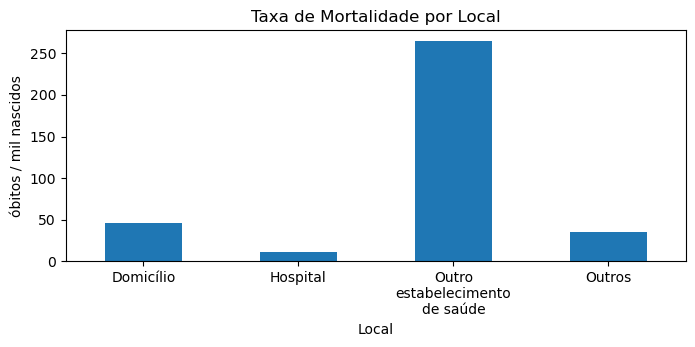

In [55]:
# Local da Ocorrência

df_local = df_final.groupby(['local_ocorrencia','obito']).size().unstack('obito')
df_local['taxa'] = round(df_local['sim'] / df_local['não'] * 1000,1)
print(df_local)

df_local2 = df_local[df_local.index != 'Não Informado']
fig, axs = plt.subplots(figsize=(8,3))  

df_local2['taxa'].plot.bar()
plt.xlabel('Local')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Local')
labels = df_local2.index.tolist()
labels = ['\n'.join(wrap(l,15)) for l in labels]
plt.xticks(range(len(labels)), labels, rotation=0)
plt.show()

obito     não   sim   taxa
sexo                      
0         219    45  205.5
1      546395  7119   13.0
2      523297  5879   11.2


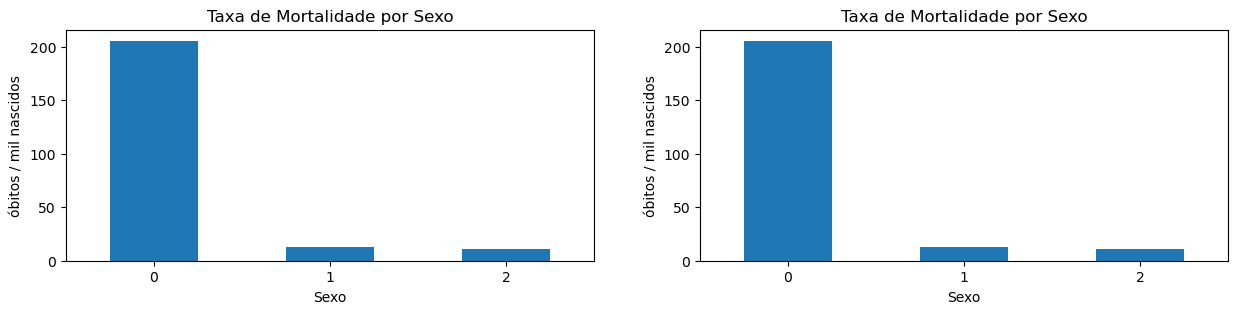

In [56]:
# Sexo

df_sexo = df_final.groupby(['sexo','obito']).size().unstack('obito')
df_sexo['taxa'] = round(df_sexo['sim'] / df_sexo['não'] * 1000,1)
print(df_sexo)

df_sexo2 = df_sexo[df_sexo.index != 'Ignorado']
fig, axs = plt.subplots(figsize=(15,3))  

plt.subplot(1,2,1)
df_sexo['taxa'].plot.bar()
plt.xlabel('Sexo')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Sexo')
plt.xticks(rotation=0)

plt.subplot(1,2,2)
df_sexo2['taxa'].plot.bar()
plt.xlabel('Sexo')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Sexo')
plt.xticks(rotation=0)

plt.show()

obito             não   sim  taxa
raca_cor                         
Amarela          2865    12   4.2
Branca         361504  4812  13.3
Indígena          727    10  13.8
Não Informado   18369   769  41.9
Parda          555900  6588  11.9
Preta          130546   852   6.5


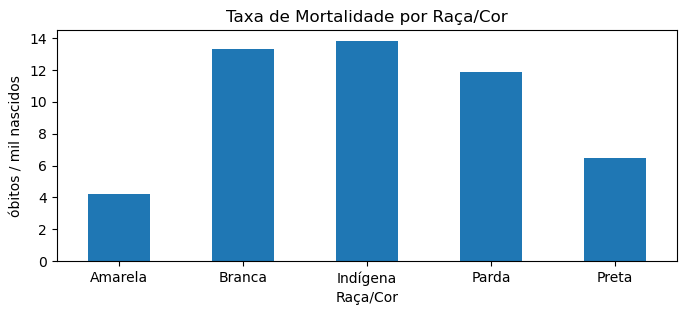

In [57]:
# Raça/Cor

df_raca_cor = df_final.groupby(['raca_cor','obito']).size().unstack('obito')
df_raca_cor['taxa'] = round(df_raca_cor['sim'] / df_raca_cor['não'] * 1000,1)
print(df_raca_cor)

df_raca_cor2 = df_raca_cor[df_raca_cor.index != 'Não Informado']
fig, axs = plt.subplots(figsize=(8,3))  

df_raca_cor2['taxa'].plot.bar()
plt.xlabel('Raça/Cor')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Raça/Cor')
plt.xticks(rotation=0)

plt.show()

obito               não    sim   taxa
gravidez                             
única           1045431  11394   10.9
dupla             23294   1073   46.1
tripla ou mais      548     64  116.8
Não Informado       638    512  802.5


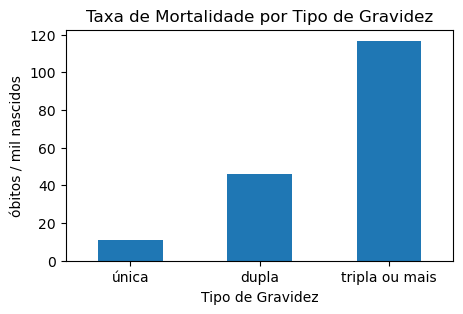

In [58]:
# Tipo de Gravidez

df_gravidez = df_final.groupby(['gravidez','obito']).size().unstack('obito')
df_gravidez['taxa'] = round(df_gravidez['sim'] / df_gravidez['não'] * 1000,1)
df_gravidez = df_gravidez.reindex(['única','dupla','tripla ou mais','Não Informado'])
print(df_gravidez)

df_gravidez2 = df_gravidez[df_gravidez.index != 'Não Informado']
fig, axs = plt.subplots(figsize=(5,3))  

df_gravidez2['taxa'].plot.bar()
plt.xlabel('Tipo de Gravidez')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Tipo de Gravidez')
plt.xticks(rotation=0)

plt.show()

obito             não   sim    taxa
gestacao                           
Menos de 22       459   554  1207.0
22 a 27          5727  3188   556.7
28 a 31         11554  2093   181.1
32 a 36         99522  2420    24.3
37 a 41        921732  3574     3.9
42 ou mais      18222    57     3.1
Não Informado   12695  1157    91.1


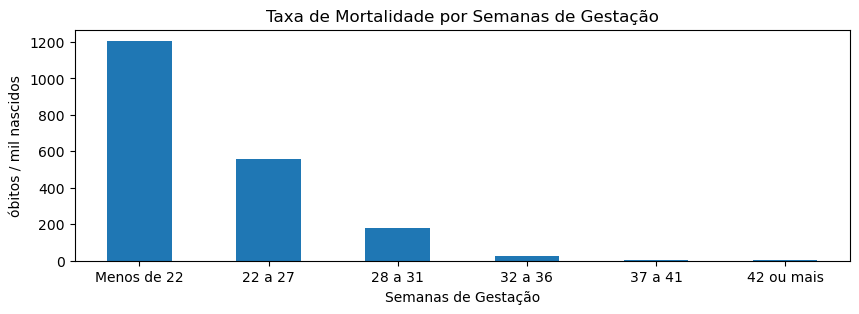

In [59]:
# Semanas de Gestação

df_gestacao = df_final.groupby(['gestacao','obito']).size().unstack('obito')
df_gestacao['taxa'] = round(df_gestacao['sim'] / df_gestacao['não'] * 1000,1)
df_gestacao = df_gestacao.reindex(['Menos de 22','22 a 27','28 a 31','32 a 36','37 a 41','42 ou mais','Não Informado'])
print(df_gestacao)

df_gestacao2 = df_gestacao[df_gestacao.index != 'Não Informado']

fig, axs = plt.subplots(figsize=(10,3))  
df_gestacao2['taxa'].plot.bar()
plt.xlabel('Semanas de Gestação')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Semanas de Gestação')
plt.xticks(rotation=0)

plt.show()

obito             não   sim    taxa
parto                              
Não Informado     519   686  1321.8
cesáreo        622049  6610    10.6
vaginal        447343  5747    12.8


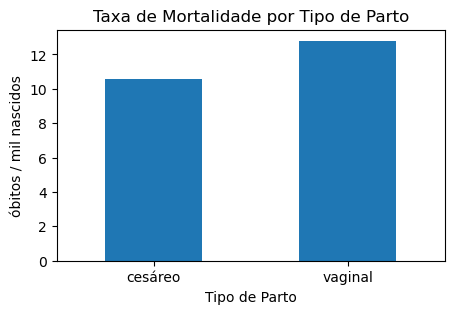

In [60]:
# Tipo de Parto

df_parto = df_final.groupby(['parto','obito']).size().unstack('obito')
df_parto['taxa'] = round(df_parto['sim'] / df_parto['não'] * 1000,1)
print(df_parto)

df_parto2 = df_parto[df_parto.index != 'Não Informado']
fig, axs = plt.subplots(figsize=(5,3))  

df_parto2['taxa'].plot.bar()
plt.xlabel('Tipo de Parto')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Tipo de Parto')
plt.xticks(rotation=0)

plt.show()

obito                   não   sim   taxa
escolaridade_mae                        
Sem escolaridade       1409   427  303.1
Fundamental I         30206   733   24.3
Fundamental II       246209  3265   13.3
Médio                556371  4957    8.9
Superior incompleto   57469   539    9.4
Superior completo    161048  1116    6.9
Não Informado         17199  2006  116.6


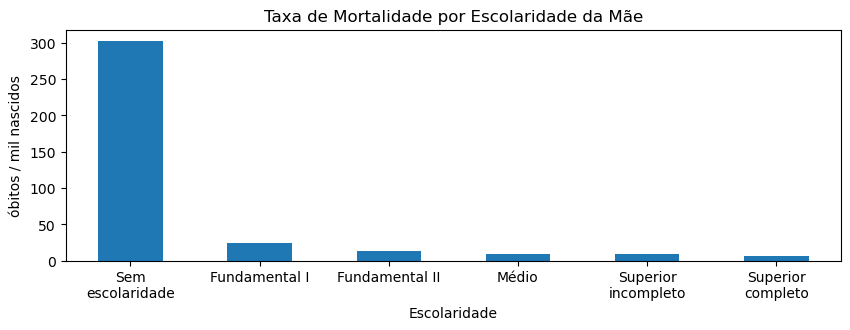

In [61]:
# Escolaridade da Mãe

df_escmae = df_final.groupby(['escolaridade_mae','obito']).size().unstack('obito')
df_escmae['taxa'] = round(df_escmae['sim'] / df_escmae['não'] * 1000,1)
df_escmae = df_escmae.reindex(['Sem escolaridade','Fundamental I','Fundamental II','Médio',
                               'Superior incompleto','Superior completo','Não Informado'])
print(df_escmae)

df_escmae2 = df_escmae[df_escmae.index != 'Não Informado']
fig, axs = plt.subplots(figsize=(10,3))  

df_escmae2['taxa'].plot.bar()
plt.xlabel('Escolaridade')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Escolaridade da Mãe')

labels = df_escmae2.index.tolist()
labels = ['\n'.join(wrap(l,15)) for l in labels]
plt.xticks(range(len(labels)), labels, rotation=0)

plt.show()


 obito                                     causa_anomalia     não     sim
0       Algumas afecções originadas no período perinatal     NaN  7344.0
1      Malformações congênitas, deformidades e anomal...  6163.0  2866.0
2             Algumas doenças infecciosas e parasitárias     NaN   705.0
3                       Doenças do aparelho respiratório     NaN   673.0
4          Causas externas de morbidade e de mortalidade     NaN   599.0
5      Sintomas, sinais e achados anormais de exames ...     NaN   215.0
6                             Doenças do sistema nervoso     NaN   183.0
7                       Doenças do aparelho circulatório     NaN   138.0
8         Doenças endócrinas, nutricionais e metabólicas     NaN    91.0
9                          Doenças do aparelho digestivo     NaN    79.0
10     Doenças do sangue e dos órgãos hematopoéticos ...     NaN    47.0
11                     Doenças do aparelho geniturinário     NaN    43.0
12                                  Neoplasmas (t

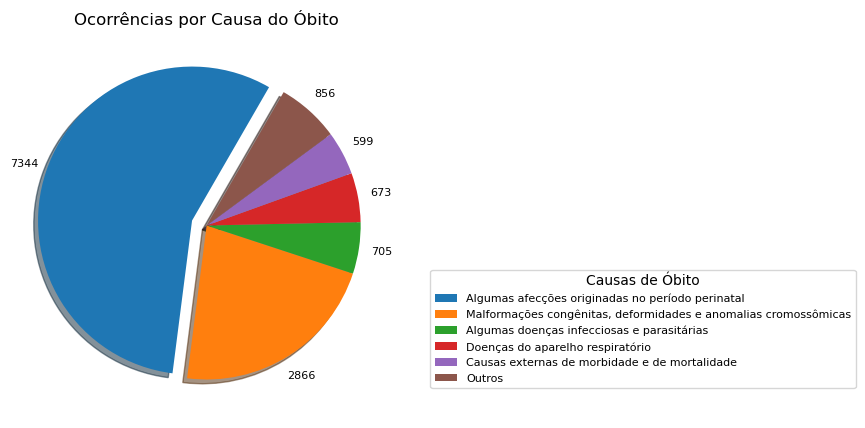

In [62]:
# Causa/Anomalia - Ocorrências por Causa

df_causa_anomalia = df_final.groupby(['causa_anomalia','obito']).size().unstack('obito')
df_causa_anomalia = df_causa_anomalia.sort_values('sim', ascending=False).reset_index()
print('\n', df_causa_anomalia, '\n')

outros = df_causa_anomalia.iloc[5:17,2].sum()
df_causa_anomalia = df_causa_anomalia.append({'causa_anomalia':'Outros','sim':outros},ignore_index=True)
df_causa_anomalia.drop([5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)

sim = df_causa_anomalia['sim']
causa_anomalia = df_causa_anomalia['causa_anomalia']

fig, axs = plt.subplots(figsize=(15,5))
explode = (0.1,0,0,0,0,0)
wedges, texts, autotexts = axs.pie(sim,autopct=lambda v:f"{sum(sim)*v/100:.0f}",pctdistance=1.15,explode=explode,
                                   shadow=True,startangle=60,labeldistance=None)
plt.legend(causa_anomalia,title='Causas de Óbito',bbox_to_anchor=(2.2,0.4), fontsize = 8)
plt.setp(autotexts, size=8)#, weight='bold')
plt.title('Ocorrências por Causa do Óbito')
plt.xticks(rotation=0)
plt.show()


 obito                                                  não     sim    taxa
causa_anomalia                                                            
Neoplasmas (tumores)                                  14.0    34.0  2428.6
Malformações congênitas, deformidades e anomali...  6163.0  2866.0   465.0
Algumas afecções originadas no período perinatal       NaN  7344.0     NaN
Algumas doenças infecciosas e parasitárias             NaN   705.0     NaN
Causas externas de morbidade e de mortalidade          NaN   599.0     NaN
Doenças da pele e do tecido subcutâneo                 NaN    14.0     NaN
Doenças do aparelho circulatório                       NaN   138.0     NaN
Doenças do aparelho digestivo                          NaN    79.0     NaN
Doenças do aparelho geniturinário                      NaN    43.0     NaN
Doenças do aparelho respiratório                       NaN   673.0     NaN
Doenças do olho e anexos                               NaN     1.0     NaN
Doenças do ouvido e da 

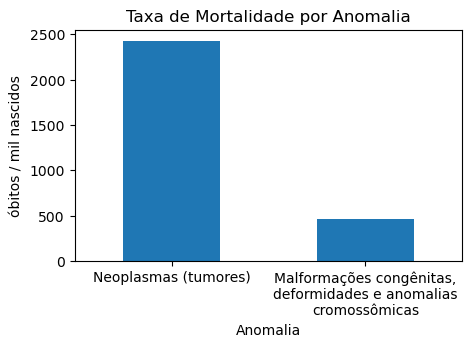

In [63]:
# Causa/Anomalia - Taxa de Mortalidade por Anomalia

df_causa_anomalia = df_final.groupby(['causa_anomalia','obito']).size().unstack('obito')
df_causa_anomalia['taxa'] = round(df_causa_anomalia['sim'] / df_causa_anomalia['não'] * 1000,1)
df_causa_anomalia = df_causa_anomalia.sort_values('taxa', ascending=False)
print('\n', df_causa_anomalia, '\n')

df_causa_anomalia = df_causa_anomalia.loc[(df_causa_anomalia['taxa'].notnull())]

fig, axs = plt.subplots(figsize=(5,3))  

df_causa_anomalia['taxa'].plot.bar()
plt.xlabel('Anomalia')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Anomalia')

labels = df_causa_anomalia.index.tolist()
labels = ['\n'.join(wrap(l,30)) for l in labels]
plt.xticks(range(len(labels)), labels, rotation=0)

plt.show()

### 4.3 Análise dos atributos quantitativos

### **Idade da Mãe**

Registros com valores extremos:

        data_ocorrencia  idade_mae
7734         2016-01-13       99.0
80266        2016-04-29       99.0
213164       2016-12-15       99.0
261500       2017-03-07       99.0
339135       2017-06-30       99.0
393650       2017-09-27       99.0
615313       2018-09-21       99.0
673463       2019-01-05       99.0
686637       2019-01-27       99.0
693657       2019-02-07       99.0
722539       2019-03-25       99.0
727900       2019-04-03       99.0
802371       2019-08-06       99.0
806622       2019-08-13       99.0
808602       2019-08-17       99.0
832903       2019-09-28       99.0
836138       2019-10-04       99.0
839578       2019-10-11       99.0
845767       2019-10-23       99.0
861675       2019-11-24       99.0
901821       2020-02-06       99.0
934660       2020-04-02       99.0
975067       2020-06-08       99.0
1000276      2020-07-24       99.0
1041834      2020-10-10       99.0
1048874      2020-10-26       99.0
1062267      2020-11-2

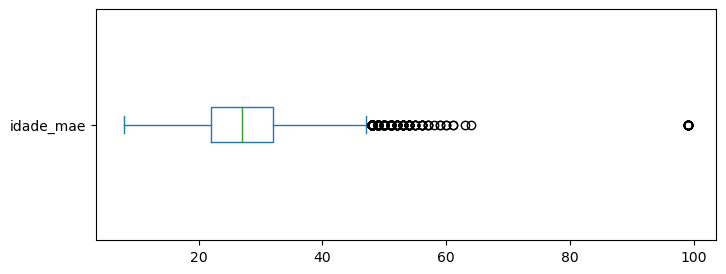

In [64]:
# Detectando OUTLIERS

df_idade_mae = df_final.iloc[:,[3,11]]
index_idade_mae = df_final[(df_final['idade_mae'] == max(df_final['idade_mae']))].index.tolist()
print("Registros com valores extremos:\n",df_idade_mae.loc[index_idade_mae], sep='\n')

df_final['idade_mae'].plot(kind="box", figsize=(8,3), vert=False)
plt.show()

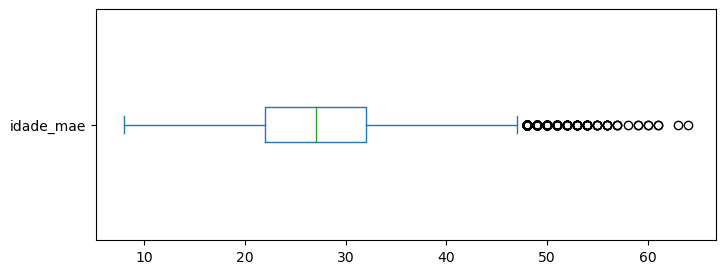

In [65]:
# Excluindo OUTLIERS

df_idade_mae = df_final.drop(index_idade_mae)

df_idade_mae['idade_mae'].plot(kind="box", figsize=(8,3), vert=False)
plt.show()

In [66]:
df_idade_mae2 = df_idade_mae.groupby(['idade_mae','obito']).size().unstack('obito')
print(df_idade_mae2)

# O registro com idade_mae=8.0 provavelmente é um erro, visto que além de ser uma idade muito baixa, 
# não há registro de nascido vivo com idade_mae com esse valor
# Para evitar que afete na distribuição, optou-se por excluir esse registro

obito          não    sim
idade_mae                
8.0            NaN    1.0
10.0           3.0    2.0
11.0          14.0    3.0
12.0         154.0    4.0
13.0        1287.0   45.0
14.0        5344.0  108.0
15.0       13350.0  223.0
16.0       22871.0  355.0
17.0       31242.0  437.0
18.0       38711.0  497.0
19.0       46267.0  629.0
20.0       51185.0  577.0
21.0       53541.0  632.0
22.0       54301.0  606.0
23.0       53976.0  537.0
24.0       53154.0  570.0
25.0       52044.0  571.0
26.0       50999.0  526.0
27.0       50340.0  532.0
28.0       48938.0  495.0
29.0       48122.0  455.0
30.0       47686.0  461.0
31.0       45907.0  446.0
32.0       43365.0  464.0
33.0       40782.0  374.0
34.0       39368.0  405.0
35.0       36325.0  396.0
36.0       32782.0  354.0
37.0       28265.0  364.0
38.0       23587.0  273.0
39.0       18335.0  249.0
40.0       13904.0  214.0
41.0        9629.0  156.0
42.0        6199.0  119.0
43.0        3698.0   80.0
44.0        1998.0   46.0
45.0        

Idade da mãe mínima:
10.0



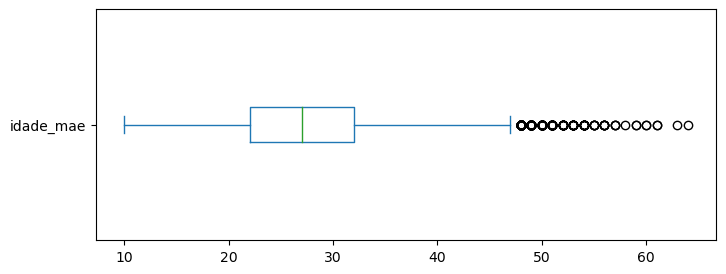

In [67]:
df_idade_mae = df_idade_mae.drop(df_idade_mae.loc[(df_idade_mae['idade_mae']==8)].index.tolist())
print("Idade da mãe mínima:\n{0}\n".format(min(df_idade_mae['idade_mae'])))

df_idade_mae['idade_mae'].plot(kind="box", figsize=(8,3), vert=False)
plt.show()

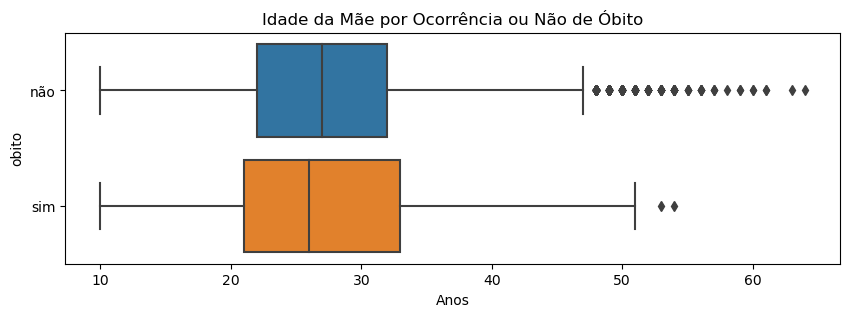

In [68]:
boxplot = sns.boxplot(x="idade_mae",y="obito", data=df_idade_mae, orient='h')
boxplot.figure.set_size_inches(10,3)
boxplot.set(title='Idade da Mãe por Ocorrência ou Não de Óbito', xlabel='Anos')
plt.show()

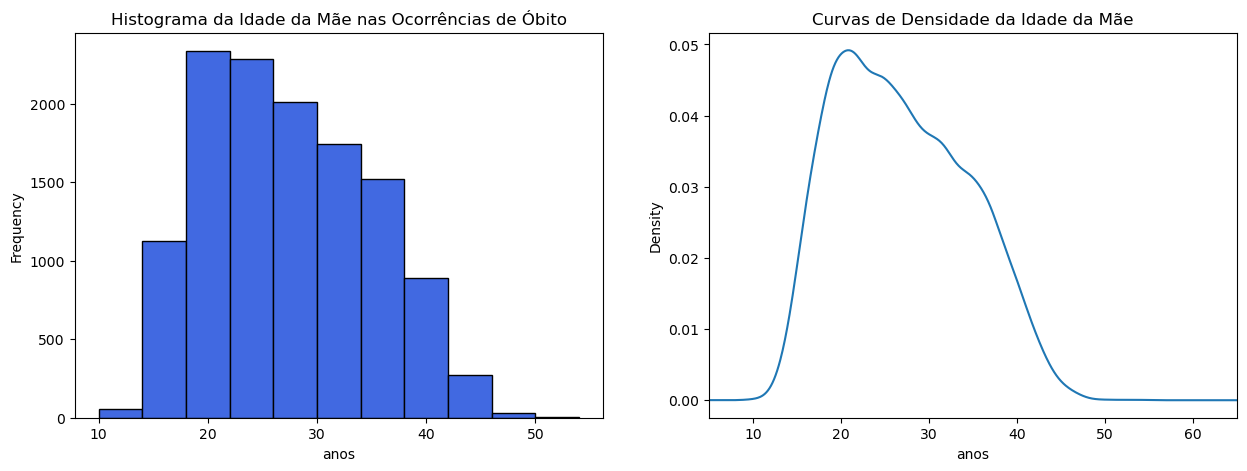

In [69]:
# Histograma e Densidade considerando somente as ocorrências de óbito

obitos = df_idade_mae.loc[(df_idade_mae['obito']=='sim')]

fig, axs = plt.subplots(figsize=(15, 5))  

plt.subplot(1,2,1)
obitos['idade_mae'].plot.hist(bins = 11, ec = 'black', color = 'royalblue')
plt.title('Histograma da Idade da Mãe nas Ocorrências de Óbito')
plt.xlabel('anos')

plt.subplot(1,2,2)
obitos['idade_mae'].plot.density()
plt.title('Curvas de Densidade da Idade da Mãe')
plt.xlabel('anos')
plt.xlim(5, 65) # definir limite do eixo

plt.show()

obito              não     sim  taxa
faixa_etaria                        
(9.0, 14.0]     6802.0   162.0  23.8
(14.0, 19.0]  152441.0  2141.0  14.0
(19.0, 24.0]  266157.0  2922.0  11.0
(24.0, 29.0]  250443.0  2579.0  10.3
(29.0, 34.0]  217108.0  2150.0   9.9
(34.0, 39.0]  139294.0  1636.0  11.7
(39.0, 44.0]   35428.0   615.0  17.4
(44.0, 49.0]    2049.0    57.0  27.8
(49.0, 54.0]     144.0     4.0  27.8


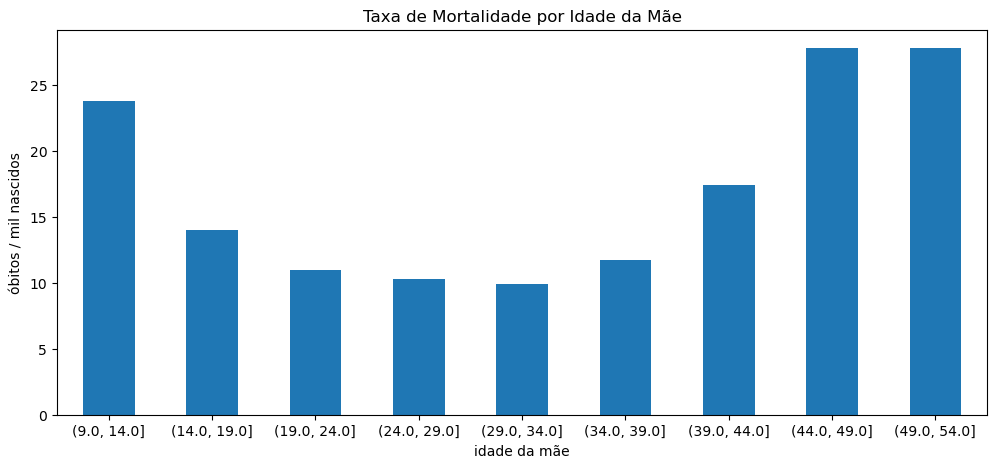

In [70]:
# Gráfico de barras da taxa de mortalidade por faixa etária da mãe

df_idade_mae2 = df_idade_mae.groupby(['idade_mae','obito']).size().unstack('obito').reset_index()
faixas_etarias = np.arange(df_idade_mae2['idade_mae'].min()-1, df_idade_mae2['idade_mae'].max()+1, 5)
df_idade_mae2['faixa_etaria'] = pd.cut(df_idade_mae2['idade_mae'], faixas_etarias)
df_idade_mae2 = df_idade_mae2.drop(columns=['idade_mae'])
df_idade_mae2 = df_idade_mae2.groupby('faixa_etaria').sum() #.reset_index()

df_idade_mae2['taxa'] = round(df_idade_mae2['sim'] / df_idade_mae2['não'] * 1000,1)
df_idade_mae2 = df_idade_mae2[(df_idade_mae2['taxa']!=0)]

print(df_idade_mae2)

fig, axs = plt.subplots(figsize=(12,5))  

df_idade_mae2['taxa'].plot.bar()
plt.xlabel('idade da mãe')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Idade da Mãe')
plt.xticks(rotation=0)
plt.show()

### **Peso**

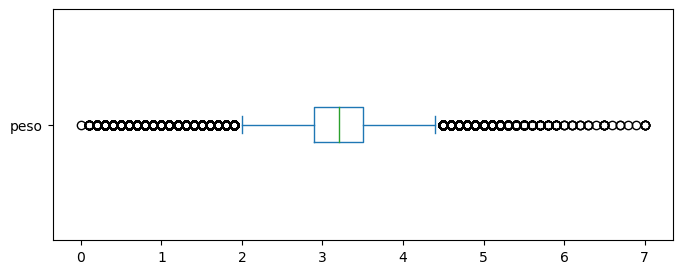

In [71]:
# Detectando OUTLIERS

df_peso = df_final.iloc[:,[3,10]]
df_final['peso'].plot(kind="box", figsize=(8,3), vert=False)
plt.show()

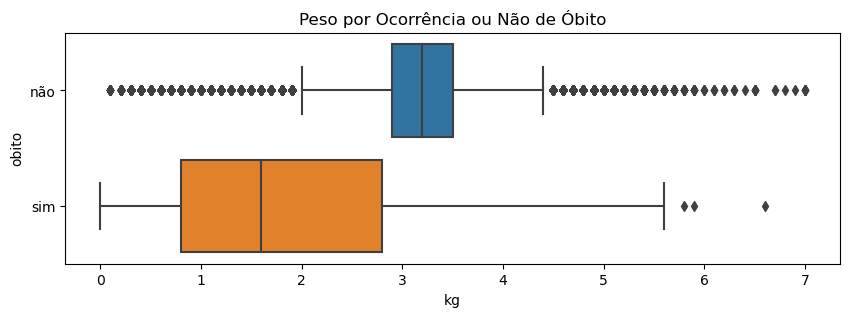

In [72]:
boxplot = sns.boxplot(x="peso",y="obito", data=df_final, orient='h')
boxplot.figure.set_size_inches(10,3)
boxplot.set(title='Peso por Ocorrência ou Não de Óbito', xlabel='kg')
plt.show()

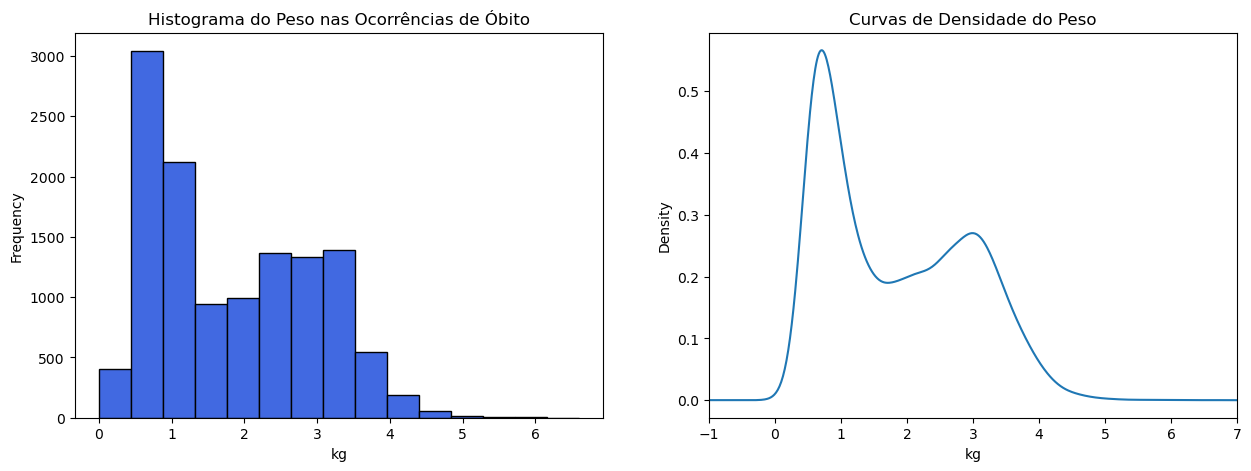

In [73]:
# Histograma e Densidade considerando somente as ocorrências de óbito

obitos = df_final.loc[(df_final['obito']=='sim')]

fig, axs = plt.subplots(figsize=(15, 5))  

plt.subplot(1,2,1)
obitos['peso'].plot.hist(bins = 15, ec = 'black', color = 'royalblue')
plt.title('Histograma do Peso nas Ocorrências de Óbito')
plt.xlabel('kg')

plt.subplot(1,2,2)
obitos['peso'].plot.density()
plt.title('Curvas de Densidade do Peso')
plt.xlabel('kg')
plt.xlim(-1, 7) # definir limite do eixo

plt.show()

obito            não     sim   taxa
faixas                             
(0.0, 0.5]    1914.0  1008.0  526.6
(0.5, 1.0]    6659.0  3543.0  532.1
(1.0, 1.5]    9751.0  1518.0  155.7
(1.5, 2.0]   21490.0  1173.0   54.6
(2.0, 2.5]   71274.0  1292.0   18.1
(2.5, 3.0]  281629.0  1660.0    5.9
(3.0, 3.5]  425932.0  1391.0    3.3
(3.5, 4.0]  206423.0   622.0    3.0
(4.0, 4.5]   39172.0   147.0    3.8
(4.5, 5.0]    4999.0    30.0    6.0
(5.0, 5.5]     546.0     7.0   12.8
(5.5, 6.0]      70.0     3.0   42.9
(6.0, 6.5]      18.0     0.0    0.0
(6.5, 7.0]      10.0     1.0  100.0


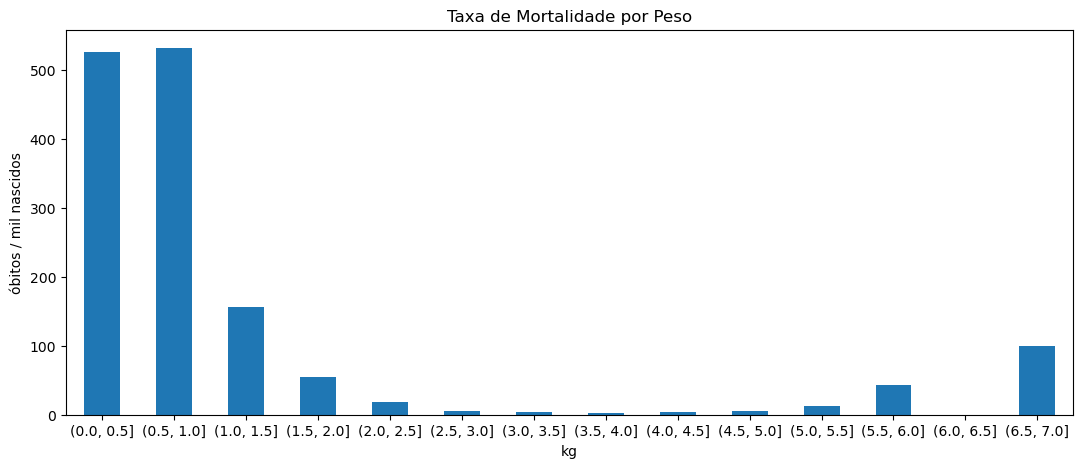

In [74]:
# Gráfico de barras da taxa de mortalidade por peso

df_peso = df_final.groupby(['peso','obito']).size().unstack('obito').reset_index()
faixas = np.arange(df_peso['peso'].min(), df_peso['peso'].max()+0.001, 0.5)
df_peso['faixas'] = pd.cut(df_peso['peso'], faixas)
df_peso = df_peso.drop(columns=['peso'])
df_peso = df_peso.groupby('faixas').sum() #.reset_index()

df_peso['taxa'] = round(df_peso['sim'] / df_peso['não'] * 1000,1)
#df_idade_mae2 = df_idade_mae2[(df_idade_mae2['taxa']!=0)]

print(df_peso)

fig, axs = plt.subplots(figsize=(13,5))  

df_peso['taxa'].plot.bar()
plt.xlabel('kg')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade por Peso')
plt.xticks(rotation=0)
plt.show()

### 4.4 Matriz de Correlação

In [75]:
# Escluindo os outliers do atributo idade_mae
df_corr1 = df_completo.drop(index_idade_mae) # exclui os valores 99
df_corr1.drop(df_corr1.loc[(df_completo['idade_mae']==8)].index.tolist(),inplace=True)

#Excluindo atributos que não serão considerados e dados nulos
df_corr1 = df_completo.drop(columns=['ano','mes_ocorrencia'])
df_corr1 = df_corr1.dropna()

In [76]:
# correlação
correlacao = df_corr1.corr().round(2)
correlacao

,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae,obito
local_ocorrencia,1.00,0.00,0.00,-0.01,0.05,-0.08,0.07,-0.05,-0.09,0.09
sexo,0.00,1.00,0.01,0.01,-0.01,0.02,-0.05,0.01,-0.01,0.04
raca_cor,0.00,0.01,1.00,-0.01,-0.05,-0.14,-0.05,-0.15,-0.22,-0.01
gravidez,-0.01,0.01,-0.01,1.00,-0.23,0.01,-0.24,0.04,0.02,0.13
gestacao,0.05,-0.01,-0.05,-0.23,1.00,0.17,0.83,0.02,0.01,-0.48
parto,-0.08,0.02,-0.14,0.01,0.17,1.00,0.13,0.24,0.21,-0.11
peso,0.07,-0.05,-0.05,-0.24,0.83,0.13,1.00,0.02,0.01,-0.48
idade_mae,-0.05,0.01,-0.15,0.04,0.02,0.24,0.02,1.00,0.30,-0.04
escolaridade_mae,-0.09,-0.01,-0.22,0.02,0.01,0.21,0.01,0.30,1.00,-0.13
obito,0.09,0.04,-0.01,0.13,-0.48,-0.11,-0.48,-0.04,-0.13,1.00


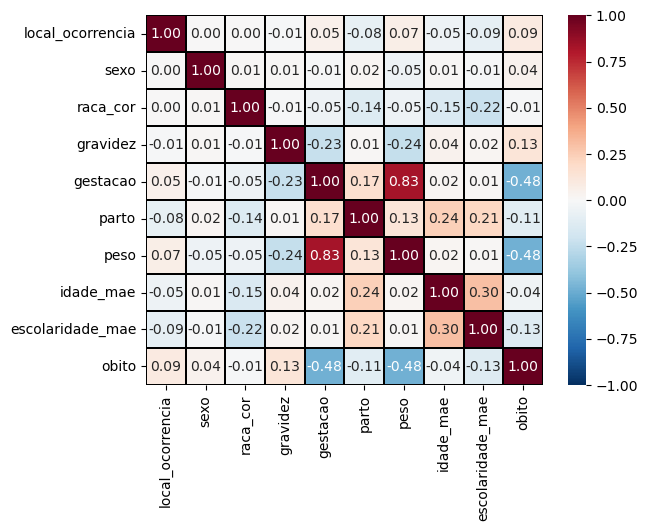

In [77]:
sns.heatmap(correlacao, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            linewidth=0.01, linecolor='black', cmap='RdBu_r')
plt.show()

In [78]:
df_corr2 = df_corr1.loc[(df_corr1['obito']==1)]
df_corr2 = df_corr2.drop(columns=['obito'])

In [79]:
correlacao = df_corr2.corr().round(2)
correlacao

,local_ocorrencia,sexo,raca_cor,gravidez,gestacao,parto,peso,idade_mae,escolaridade_mae
local_ocorrencia,1.00,-0.00,-0.00,-0.03,0.12,-0.05,0.16,-0.05,-0.09
sexo,-0.00,1.00,0.01,-0.00,0.01,0.03,-0.03,0.02,-0.01
raca_cor,-0.00,0.01,1.00,-0.01,-0.09,-0.15,-0.09,-0.15,-0.21
gravidez,-0.03,-0.00,-0.01,1.00,-0.20,0.01,-0.21,0.05,0.04
gestacao,0.12,0.01,-0.09,-0.20,1.00,0.18,0.82,0.01,-0.07
parto,-0.05,0.03,-0.15,0.01,0.18,1.00,0.13,0.24,0.17
peso,0.16,-0.03,-0.09,-0.21,0.82,0.13,1.00,-0.01,-0.08
idade_mae,-0.05,0.02,-0.15,0.05,0.01,0.24,-0.01,1.00,0.26
escolaridade_mae,-0.09,-0.01,-0.21,0.04,-0.07,0.17,-0.08,0.26,1.00


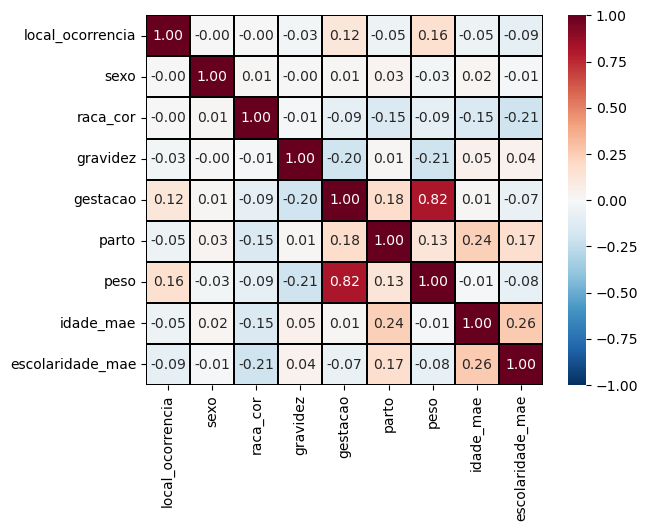

In [80]:
sns.heatmap(correlacao, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            linewidth=0.01, linecolor='black', cmap='RdBu_r')
plt.show()

### 4.5 Análise da Série Temporal

### **Exploração da série temporal**

In [81]:
df_diario = df_final.groupby(['data_ocorrencia','obito']).size().unstack('obito')
df_diario['taxa'] = round(df_diario['sim'] / df_diario['não'] * 1000,1)
print(df_diario.head())

obito              não   sim  taxa
data_ocorrencia                   
2016-01-01       442.0   5.0  11.3
2016-01-02       519.0  10.0  19.3
2016-01-03       451.0   7.0  15.5
2016-01-04       804.0   5.0   6.2
2016-01-05       723.0  12.0  16.6


In [82]:
df_diario['taxa'].isnull().sum()

2

In [83]:
df_diario['taxa'].fillna(0, inplace=True)
df_diario['taxa'].isnull().sum()

0

In [84]:
df_diario.reset_index(inplace=True)
df_diario.rename_axis('', axis='columns', inplace=True)
df_diario.drop(columns=['sim','não'], inplace=True)
df_diario.set_index(['data_ocorrencia'], inplace=True)
print(df_diario)

                 taxa
data_ocorrencia      
2016-01-01       11.3
2016-01-02       19.3
2016-01-03       15.5
2016-01-04        6.2
2016-01-05       16.6
...               ...
2020-12-27       12.5
2020-12-28        8.2
2020-12-29        9.9
2020-12-30        5.7
2020-12-31        7.1

[1827 rows x 1 columns]


In [85]:
print(df_diario.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   taxa    1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB
None


In [86]:
time_series = df_diario['taxa']
print(time_series)

data_ocorrencia
2016-01-01    11.3
2016-01-02    19.3
2016-01-03    15.5
2016-01-04     6.2
2016-01-05    16.6
              ... 
2020-12-27    12.5
2020-12-28     8.2
2020-12-29     9.9
2020-12-30     5.7
2020-12-31     7.1
Name: taxa, Length: 1827, dtype: float64


In [87]:
print(time_series.info())

<class 'pandas.core.series.Series'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Series name: taxa
Non-Null Count  Dtype  
--------------  -----  
1827 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB
None


In [88]:
print(time_series.index.min())
print(time_series.index.max())

2016-01-01 00:00:00
2020-12-31 00:00:00


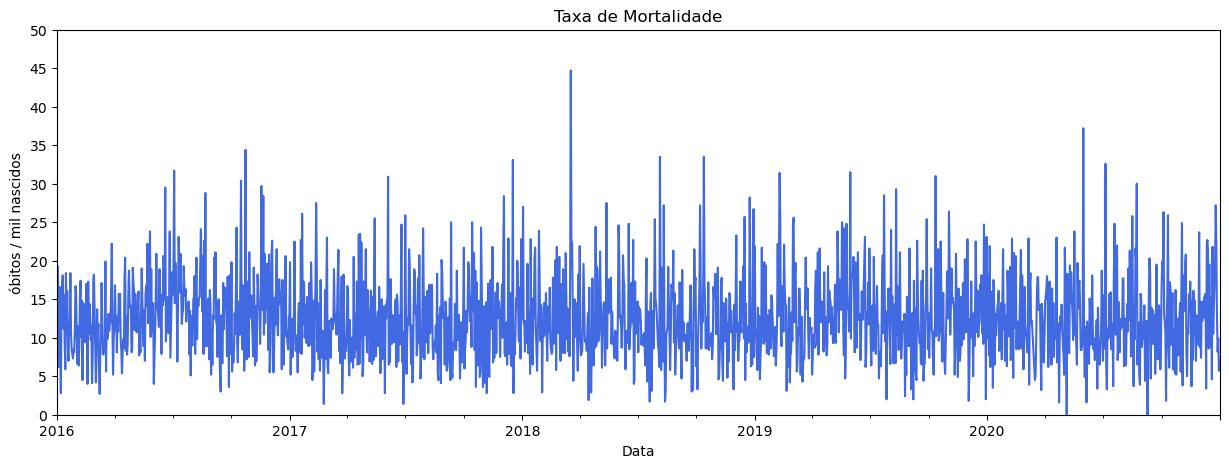

In [89]:
fig, axs = plt.subplots(figsize=(15,5))  
time_series.plot.line(color = 'royalblue')
plt.xlabel('Data')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(rotation=0)
plt.ylim(0, 50) # definir limite do eixo
plt.yticks(range(0, 51, 5)) # alterar escala do eixo
plt.show()

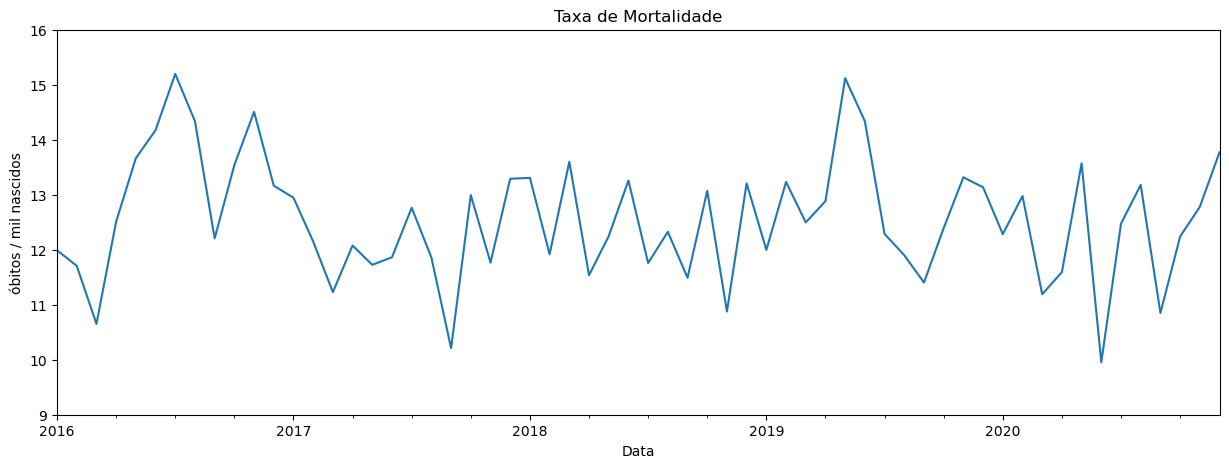

In [90]:
# Cálculo aproximado da taxa mensal
time_series_mensal1 = time_series.resample('MS').mean()

fig, axs = plt.subplots(figsize=(15,5))  
time_series_mensal1.plot.line()
plt.xlabel('Data')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(rotation=0)
plt.ylim(9, 16) # definir limite do eixo
plt.yticks(range(9, 17, 1)) # alterar escala do eixo
plt.show()

***Como se trata de uma taxa, a matemática correta é recalcular a partir do somatório dos registros de nascimentos e de óbitos***

In [91]:
# Extraindo dia da data_obito para utilizar essa coluna como agrupador por mês/ano.
df_mensal = df_final.groupby(['data_ocorrencia','obito']).size().unstack('obito')
df_mensal.reset_index(inplace=True)
df_mensal.rename_axis('', axis='columns', inplace=True)
df_mensal['data_ocorrencia'] = df_mensal['data_ocorrencia'].apply(lambda x: x.strftime('%Y-%m'))
df_mensal['data_ocorrencia'] = pd.to_datetime(df_mensal['data_ocorrencia'])
print(df_mensal.head())

  data_ocorrencia    não   sim
0      2016-01-01  442.0   5.0
1      2016-01-01  519.0  10.0
2      2016-01-01  451.0   7.0
3      2016-01-01  804.0   5.0
4      2016-01-01  723.0  12.0


In [92]:
# Agrupando e gerando a série com a taxa mensal
df_mensal = df_mensal.groupby('data_ocorrencia').sum()
df_mensal['taxa'] = round(df_mensal['sim'] / df_mensal['não'] * 1000,1)
df_mensal.drop(columns=['sim','não'], inplace=True)
time_series_mensal2 = df_mensal['taxa']
print(time_series_mensal2.head())

data_ocorrencia
2016-01-01    11.6
2016-02-01    11.5
2016-03-01    10.4
2016-04-01    12.1
2016-05-01    13.4
Name: taxa, dtype: float64


In [93]:
# Comparando com a diferença da função resample
print(time_series_mensal1.head())

data_ocorrencia
2016-01-01    11.990323
2016-02-01    11.706897
2016-03-01    10.651613
2016-04-01    12.510000
2016-05-01    13.664516
Freq: MS, Name: taxa, dtype: float64


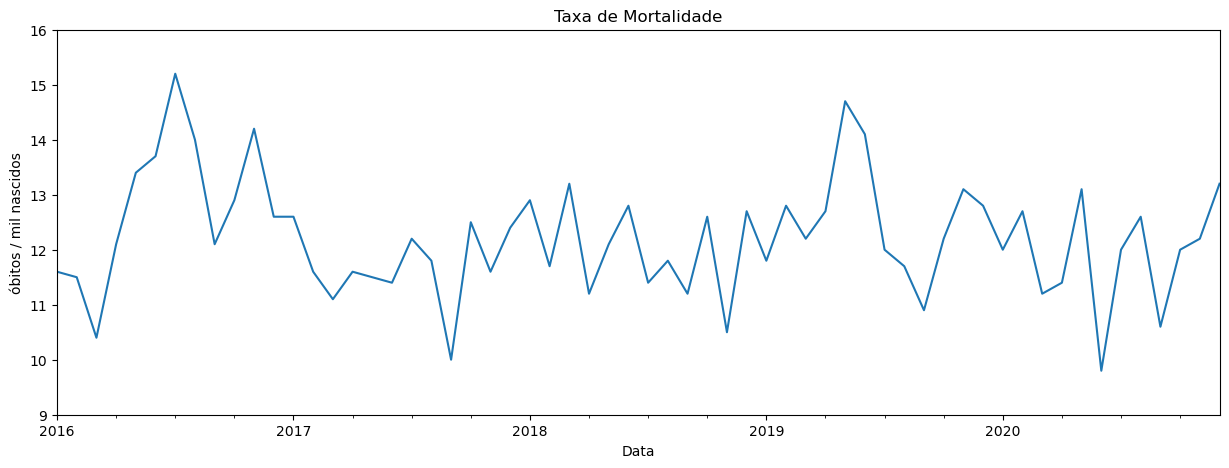

In [94]:
fig, axs = plt.subplots(figsize=(15,5))  
df_mensal['taxa'].plot.line()
plt.xlabel('Data')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(rotation=0)
plt.ylim(9, 16) # definir limite do eixo
plt.yticks(range(9, 17, 1)) # alterar escala do eixo
plt.show()

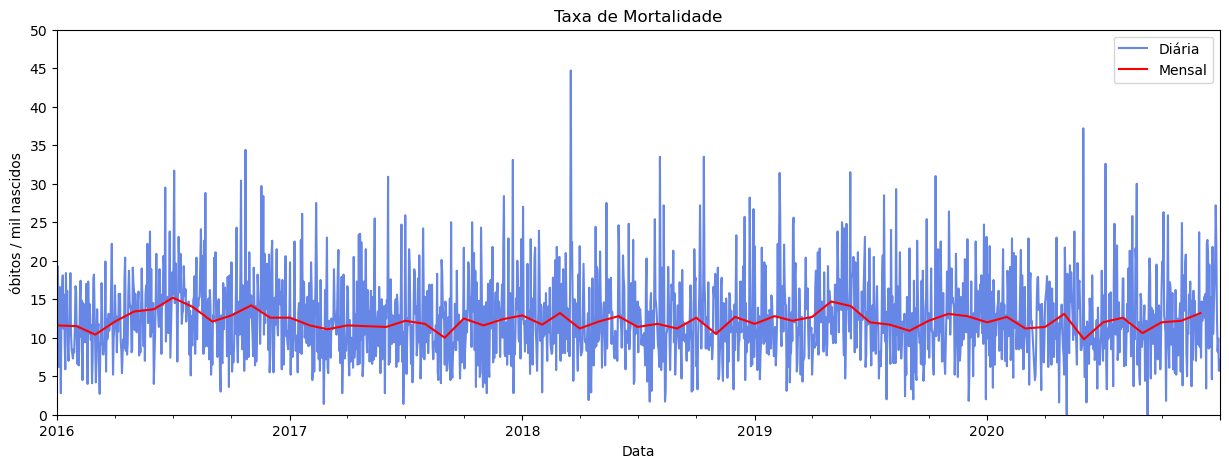

In [95]:
fig, axs = plt.subplots(figsize=(15,5))  
df_diario['taxa'].plot.line(color = 'royalblue', alpha = .8)
df_mensal['taxa'].plot.line(color = 'red')
plt.xlabel('Data')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(rotation=0)
plt.ylim(0, 50) # definir limite do eixo
plt.yticks(range(0, 51, 5)) # alterar escala do eixo
plt.legend(['Diária', 'Mensal'])
plt.show()

In [96]:
# Cálculo da taxa anual
df_ano = df_final.groupby(['ano','obito']).size().unstack('obito')
df_ano['taxa'] = round(df_ano['sim'] / df_ano['não'] * 1000,1)
df_ano.reset_index(inplace=True)
df_ano.rename_axis('', axis='columns', inplace=True)
df_ano.set_index(['ano'], inplace=True)
print(df_ano)

         não   sim  taxa
ano                     
2016  219124  2792  12.7
2017  223216  2611  11.7
2018  220481  2653  12.0
2019  207966  2620  12.6
2020  199124  2367  11.9


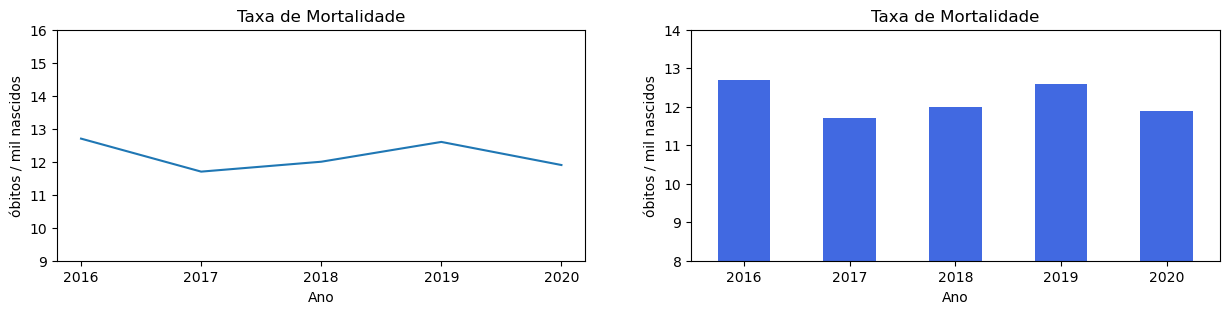

In [97]:
fig, axs = plt.subplots(figsize=(15,3))  

plt.subplot(1,2,1)
df_ano['taxa'].plot.line()
plt.xlabel('Ano')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(range(2016, 2021, 1), rotation=0)
plt.ylim(9, 16) # definir limite do eixo
plt.yticks(range(9, 17, 1)) # alterar escala do eixo

plt.subplot(1,2,2)
df_ano['taxa'].plot.bar(color = 'royalblue')
plt.xlabel('Ano')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(rotation=0)
plt.ylim(8, 14) # definir limite do eixo
plt.yticks(range(8, 15, 1)) # alterar escala do eixo
plt.show()

                        não   sim  taxa
mes_ocorrencia_desc                    
Janeiro               92562  1130  12.2
Fevereiro             89180  1073  12.0
Março                100040  1161  11.6
Abril                 95388  1124  11.8
Maio                  98691  1277  12.9
Junho                 91248  1131  12.4
Julho                 90232  1133  12.6
Agosto                87324  1078  12.3
Setembro              83780   920  11.0
Outubro               80013   996  12.4
Novembro              78706   966  12.3
Dezembro              82747  1054  12.7


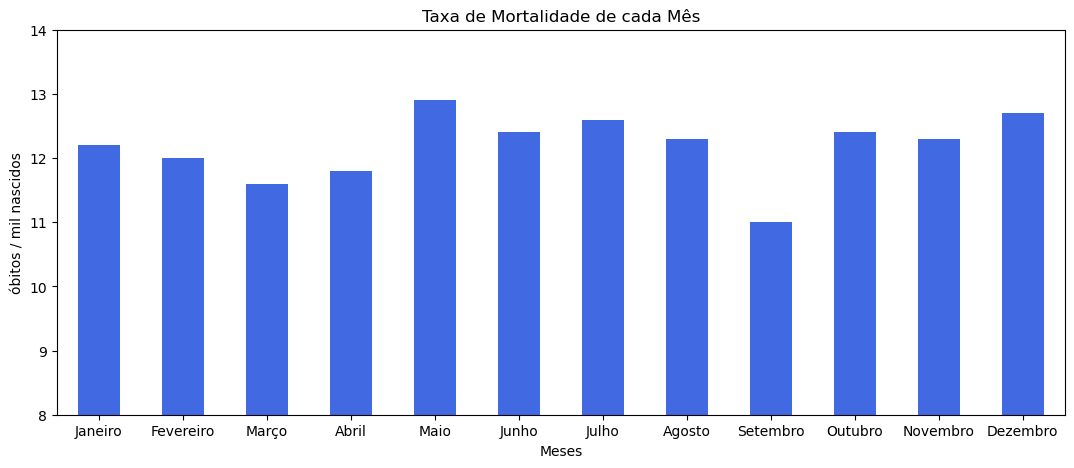

In [98]:
# Ocorrências por cada mês

df_mes = df_final.groupby(['mes_ocorrencia_desc','mes_ocorrencia','obito']).size().unstack('obito')
df_mes['taxa'] = round(df_mes['sim'] / df_mes['não'] * 1000,1)
df_mes = df_mes.sort_values('mes_ocorrencia', ascending=True).reset_index('mes_ocorrencia', drop=True)
df_mes.reset_index(inplace=True)
df_mes.rename_axis('', axis='columns', inplace=True)
df_mes.set_index(['mes_ocorrencia_desc'], inplace=True)
print(df_mes)

fig, axs = plt.subplots(figsize=(13,5))  
df_mes['taxa'].plot.bar(color = 'royalblue')
plt.xlabel('Meses')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade de cada Mês')
plt.xticks(rotation=0)
plt.ylim(8, 14) # definir limite do eixo
plt.yticks(range(8, 15, 1)) # alterar escala do eixo

plt.show()

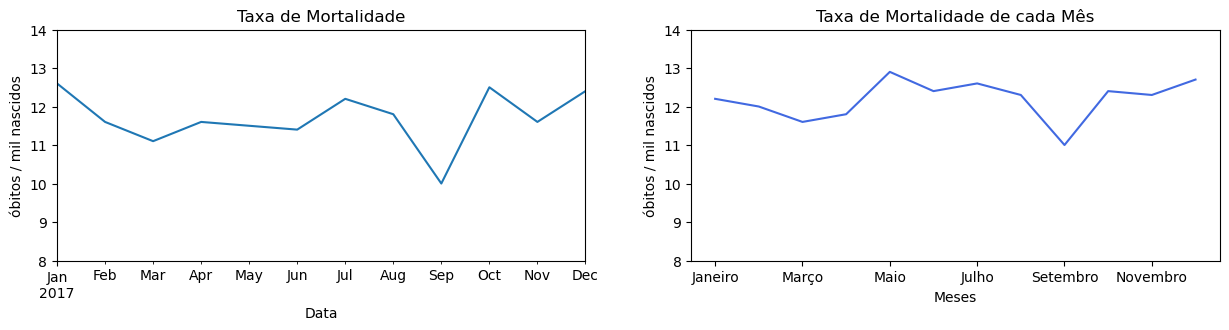

In [99]:
df_mensal_periodo = df_mensal['2017-01-01':'2017-12-31']

fig, axs = plt.subplots(figsize=(15,3))  

plt.subplot(1,2,1)
df_mensal_periodo['taxa'].plot.line()
plt.xlabel('Data')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade')
plt.xticks(rotation=0)
plt.ylim(8, 14) # definir limite do eixo
plt.yticks(range(8, 15, 1)) # alterar escala do eixo

plt.subplot(1,2,2)
df_mes['taxa'].plot.line(color = 'royalblue')
plt.xlabel('Meses')
plt.ylabel('óbitos / mil nascidos')
plt.title('Taxa de Mortalidade de cada Mês')
plt.xticks(rotation=0)
plt.ylim(8, 14) # definir limite do eixo
plt.yticks(range(8, 15, 1)) # alterar escala do eixo

plt.show()

In [100]:
# Estatística Descritiva
df_diario.describe()

,taxa
count,1827.000000
mean,12.546141
std,5.389675
min,0.000000
25%,8.800000
50%,12.000000
75%,15.500000
max,44.700000


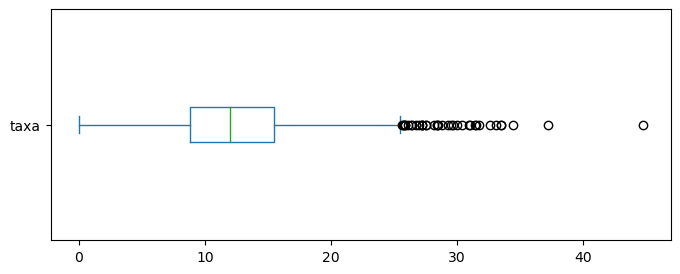

In [101]:
# Detectando OUTLIERS
df_diario['taxa'].plot(kind="box", figsize=(8,3), vert=False)
plt.show()

In [102]:
index = df_diario.nlargest(2, 'taxa').index.tolist()
print("Registros com valores extremos:\n",df_diario.loc[index], sep='\n')

Registros com valores extremos:

                 taxa
data_ocorrencia      
2018-03-18       44.7
2020-05-31       37.2


Apesar da análise apontar OUTLIERS, esses valores serão mantidos, pois podem ser devido a algum evento específico (tragédia ambiental/climática, acidente de grande proporção, entre outros.

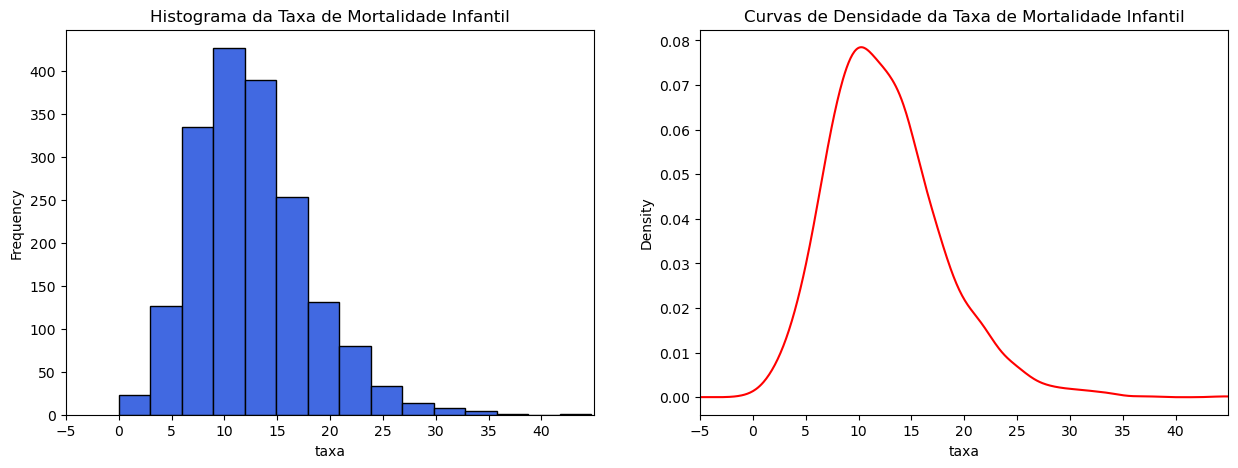

In [103]:
# Histograma e Densidade da Taxa de Mortalidade Infantil
fig, axs = plt.subplots(figsize=(15,5))  

plt.subplot(1,2,1)
df_diario['taxa'].plot.hist(bins = 15, ec = 'black', color = 'royalblue')
plt.title('Histograma da Taxa de Mortalidade Infantil')
plt.xlabel('taxa')
plt.xlim(-5, 45) # definir limite do eixo
plt.xticks(range(-5, 45, 5)) # alterar escala do eixo

plt.subplot(1,2,2)
df_diario['taxa'].plot.density(color = 'red')
plt.title('Curvas de Densidade da Taxa de Mortalidade Infantil')
plt.xlabel('taxa')
plt.xlim(-5, 45) # definir limite do eixo
plt.xticks(range(-5, 45, 5)) # alterar escala do eixo

plt.show()

### **Decomposição da série temporal**

In [104]:
decomposicao = seasonal_decompose(df_diario['taxa'])
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal
residuo = decomposicao.resid

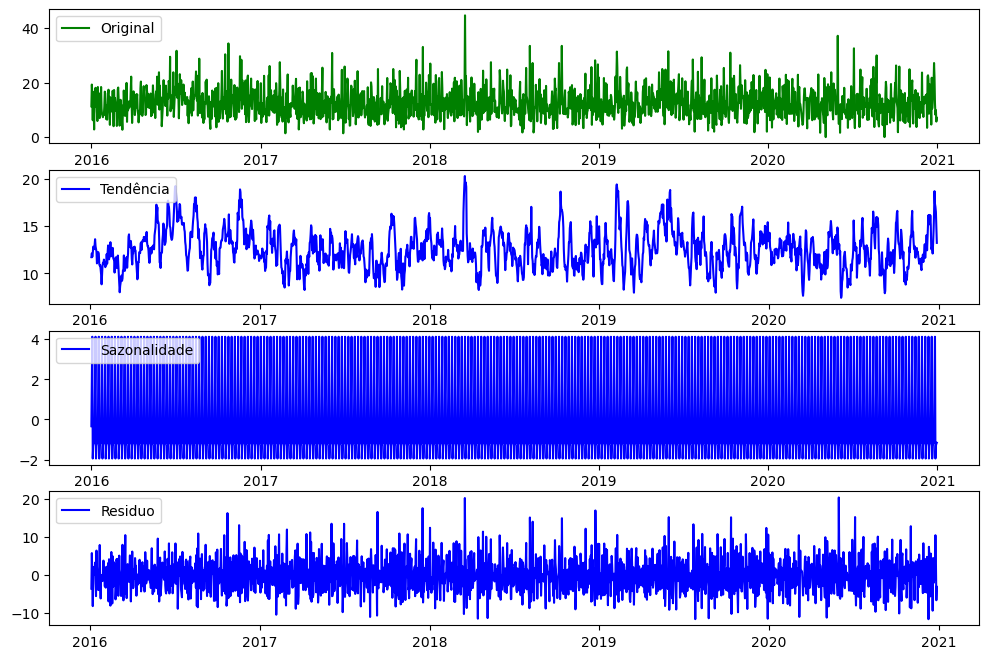

In [105]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_diario['taxa'], label='Original', color = 'green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(tendencia,label='Tendência', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sazonal,label='Sazonalidade', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuo,label='Residuo', color='blue')
plt.legend(loc='upper left')

plt.show()

### **Análise de estacionariedade (teste Dickey-Fuller)**

In [106]:
# extrair apenas os valores
X = time_series.values

# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico (ADF): {:.4f}'.format(result[0]))
print('Valor-p: {:.12f}'.format(result[1]))
print('Num de Lags : ', result[2])
print('Num de Observações usadas para ADF Regression : ', result[3])
print('Estacionário : ', result[1] < 0.05)
print('Valores Críticos:')
for key, value in result[4].items():
    print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico (ADF): -7.1739
Valor-p: 0.000000000276
Num de Lags :  25
Num de Observações usadas para ADF Regression :  1801
Estacionário :  True
Valores Críticos:
	1%: -3.4340
	5%: -2.8631
	10%: -2.5676


De acordo com o ***Valor-p***, podemos observar que os dados são ***estacionários***.

Se p < 0.05 => Dados estacionários

Se p > 0.05 => Dados não estacionários

### **Seleção dos Algoritmos de Predição**

Considerando a estrutura do dataframe que será utilizado para implementação dos algoritmos de predição, e as análises de decomposição e estacionariedade, é possível verificar que trata-se de uma série temporal univariada estacionária e sem sazonalidade.

A partir dessa conclusão foram definidos os algoritmos a serem utilizados para gerarem os modelos de predição da *Taxa de Mortalidade Infantil do Rio de Janeiro*

- Naive Approach
- Suavização Exponencial
- Modelo Auto Regressivo (AR)
- ARIMA
- Árvore de Decisão para Regressão

## 5. Criação de Modelos de Machine Learning

### 5.1. **Métricas de Avaliação dos Modelos**

- **Mean Squared Error - MSE**

Talvez seja a mais utilizada, esta função calcula a média dos erros do modelo ao quadrado. Ou seja, diferenças menores têm menos importância, enquanto diferenças maiores recebem mais peso.

***MSE = mean_squared_error(teste, previsao)***

- **Raiz do Erro Quadrático Médio - Root Mean Squared Error - RMSE**

Existe uma variação, que facilita a interpretação: o Root Mean Squared Error. Ele é simplesmente a raiz quadrada do primeiro. Neste caso, o erro volta a ter as unidades de medida originais da variável dependente.

Basta adicionar o argumento squared=False ao final da função para calcular o RMSE com scikit-learn.

***RMSE = mean_squared_error(teste, previsao, squared=False)***

- **Mean Absolute Error - MAE**

Bastante parecido com MSE, em vez de elevar a diferença entre a previsão do modelo, e o valor real, ao quadrado, ele toma o valor absoluto.

Neste caso, em vez de atribuir um peso de acordo com a magnitude da diferença, ele atribui o mesmo peso a todas as diferenças, de maneira linear.

***MAE = mean_absolute_error(teste, previsao)***

### 5.2. **Separação *train/test***

In [107]:
train_size = int(len(df_diario.taxa)*0.8)
train_set = df_diario.taxa[:train_size]
test_set = df_diario.taxa[train_size:]

print('Última data Treinamento: ', train_set.index.max())
print('Registros Treinamento: ', len(train_set))
print('Primeira data Teste: ', test_set.index.min())
print('Registros Teste: ', len(test_set))

Última data Treinamento:  2019-12-31 00:00:00
Registros Treinamento:  1461
Primeira data Teste:  2020-01-01 00:00:00
Registros Teste:  366


In [108]:
train_set.index

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='data_ocorrencia', length=1461, freq=None)

In [109]:
test_set.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='data_ocorrencia', length=366, freq=None)

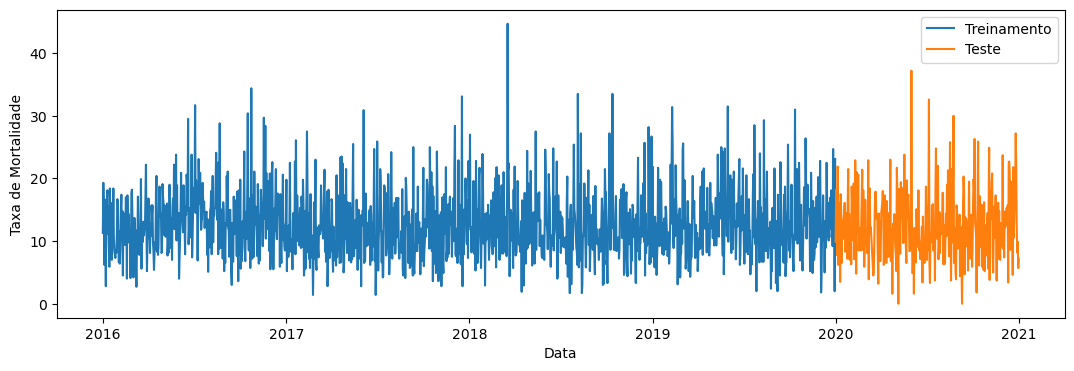

In [110]:
fig, axs = plt.subplots(figsize=(13,4))  
plt.plot(train_set)
plt.plot(test_set)
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.legend(['Treinamento', 'Teste'])
plt.show()

### 5.3. **Naive Approach**

No "Modelo Ingênuo", a previsão de P<sub>t+1</sub> é apenas uma mera observação do período imediatamente anterior (P<sub>t</sub>).




In [111]:
# criar um dataframe para armazenar as previsões
previsao = test_set.copy()
previsao = pd.DataFrame(previsao, columns=['taxa'])
previsao

,taxa
data_ocorrencia,
2020-01-01,9.9
2020-01-02,18.2
2020-01-03,13.1
2020-01-04,7.7
2020-01-05,21.9
2020-01-06,6.2
2020-01-07,12.7
2020-01-08,8.1
2020-01-09,16.0


In [112]:
train_set.tail()

data_ocorrencia
2019-12-27    24.7
2019-12-28    10.2
2019-12-29    19.8
2019-12-30     2.0
2019-12-31    23.1
Name: taxa, dtype: float64

In [113]:
# copiar o último valor do dataset train_set e atribuir à previsao['naive']
previsao['naive'] = train_set.iloc[-1]
previsao

,taxa,naive
data_ocorrencia,,
2020-01-01,9.9,23.1
2020-01-02,18.2,23.1
2020-01-03,13.1,23.1
2020-01-04,7.7,23.1
2020-01-05,21.9,23.1
2020-01-06,6.2,23.1
2020-01-07,12.7,23.1
2020-01-08,8.1,23.1
2020-01-09,16.0,23.1


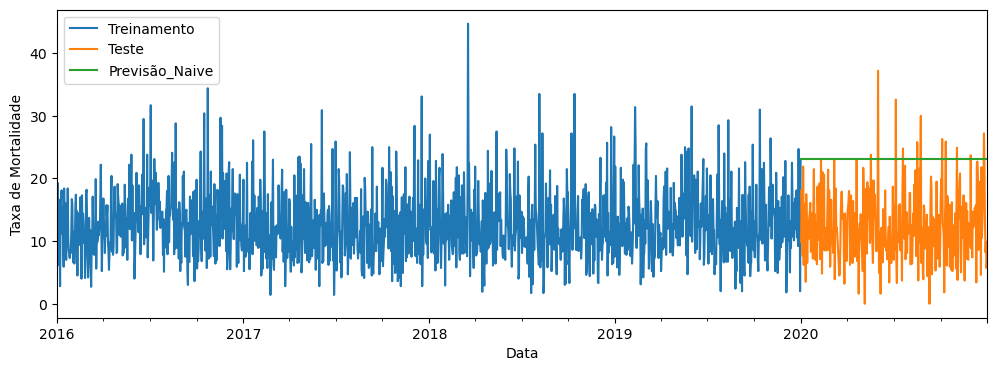

In [114]:
# plotar train/test e previsão
fig, ax = plt.subplots(figsize=(12,4))
train_set.plot()
test_set.plot()
previsao['naive'].plot()
plt.legend(['Treinamento', 'Teste', 'Previsão_Naive'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [115]:
# Calcular o erro da previsão
print("Erro do Modelo Naive:")
print('MSE = ', round(mean_squared_error(previsao.taxa, previsao.naive),4))
print('RMSE = ', round(mean_squared_error(previsao.taxa, previsao.naive, squared=False),4))
print('MAE = ', round(mean_absolute_error(previsao.taxa, previsao.naive),4))

Erro do Modelo Naive:
MSE =  147.0254
RMSE =  12.1254
MAE =  11.1183


### 5.4. **Suavização Exponencial**

Predições usando as médias ponderadas das observações passadas. Os pesos decaem exponencialmente conforme observação mais antiga. As observações mais recentes tem maior peso.

In [116]:
modelo_001 = ExponentialSmoothing(train_set).fit(smoothing_level=0.01)
previsao001 = modelo_001.forecast(len(test_set))

modelo_01 = ExponentialSmoothing(train_set).fit(smoothing_level=0.1)
previsao01 = modelo_01.forecast(len(test_set))

modelo_05 = ExponentialSmoothing(train_set).fit(smoothing_level=0.5)
previsao05 = modelo_05.forecast(len(test_set))

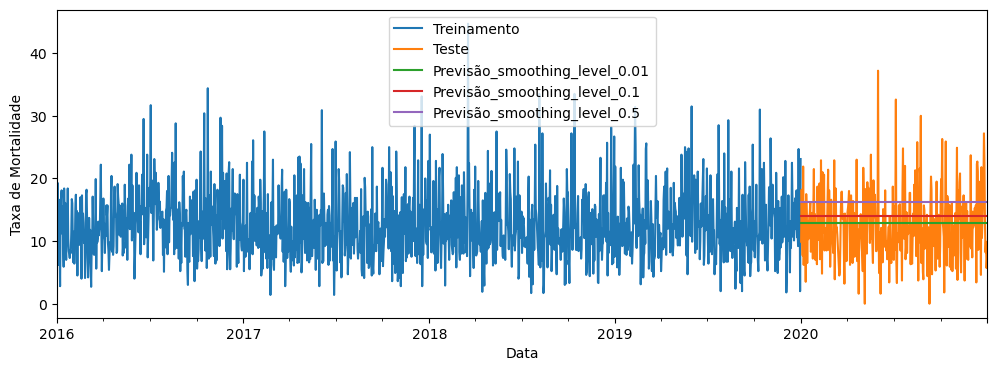

In [117]:
# plotar train/test e previsão
fig, ax = plt.subplots(figsize=(12,4))
train_set.plot()
test_set.plot()
previsao001.plot()
previsao01.plot()
previsao05.plot()
ax.legend(['Treinamento','Teste','Previsão_smoothing_level_0.01','Previsão_smoothing_level_0.1','Previsão_smoothing_level_0.5'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [118]:
# Calcular o erro da previsão
print("Erro do Modelo Exponential Smoothing (smoothing_level=0.01):")
print('MSE = ', round(mean_squared_error(test_set, previsao001),4))
print('RMSE = ', round(mean_squared_error(test_set, previsao001, squared=False),4))
print('MAE = ', round(mean_absolute_error(test_set, previsao001),4),'\n')
print("Erro do Modelo Exponential Smoothing (smoothing_level=0.1):")
print('MSE = ', round(mean_squared_error(test_set, previsao01),4))
print('RMSE = ', round(mean_squared_error(test_set, previsao01, squared=False),4))
print('MAE = ', round(mean_absolute_error(test_set, previsao01),4),'\n')
print("Erro do Modelo Exponential Smoothing (smoothing_level=0.5):")
print('MSE = ', round(mean_squared_error(test_set, previsao05),4))
print('RMSE = ', round(mean_squared_error(test_set, previsao05, squared=False),4))
print('MAE = ', round(mean_absolute_error(test_set, previsao05),4),'\n')

Erro do Modelo Exponential Smoothing (smoothing_level=0.01):
MSE =  29.5054
RMSE =  5.4319
MAE =  4.2833 

Erro do Modelo Exponential Smoothing (smoothing_level=0.1):
MSE =  32.3269
RMSE =  5.6857
MAE =  4.5917 

Erro do Modelo Exponential Smoothing (smoothing_level=0.5):
MSE =  45.4327
RMSE =  6.7404
MAE =  5.674 



### 5.5. **Função de Autocorrelação (ACF) e Função de Autocorrelação Parcial (PACF)**

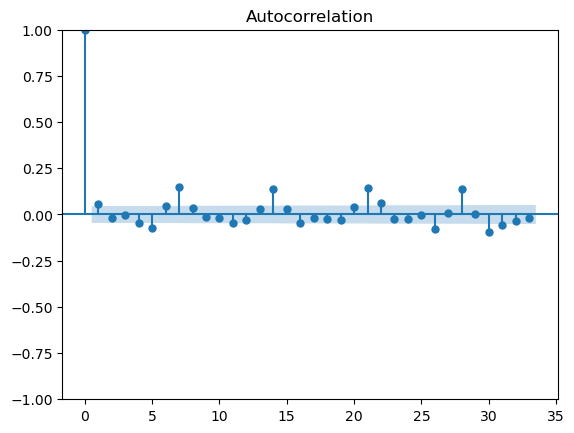

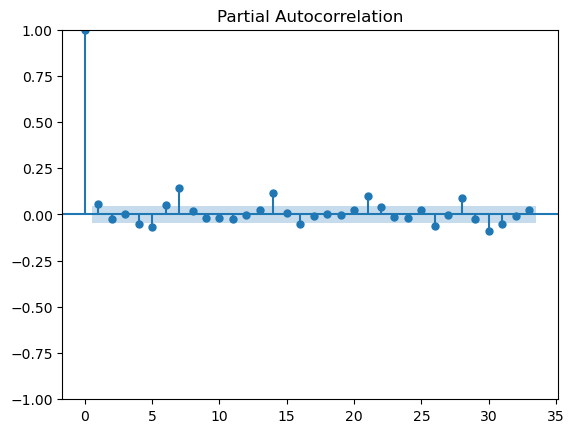

In [119]:
plot_acf(df_diario.taxa)
plt.show()

plot_pacf(df_diario.taxa)
plt.show()

Para o modelo Auto Regressivo, serão simulados 4 cenários considerando diferentes números de lags (1,7,14,21).

### 5.6. **Modelo Auto Regressivo (AR)**

In [120]:
modelo_ar1 = AutoReg(train_set, lags = [1]).fit()
modelo_ar1.params

const      11.864783
taxa.L1     0.060075
dtype: float64

In [121]:
previsao_ar1 = modelo_ar1.params[0] + modelo_ar1.params[1] * test_set.shift(1)

In [122]:
df_test_ar1 = test_set.to_frame()
df_test_ar1['previsao'] = previsao_ar1
df_test_ar1.dropna(inplace=True)
df_test_ar1.head()

,taxa,previsao
data_ocorrencia,,
2020-01-02,18.2,12.459527
2020-01-03,13.1,12.958152
2020-01-04,7.7,12.651768
2020-01-05,21.9,12.327362
2020-01-06,6.2,13.180430


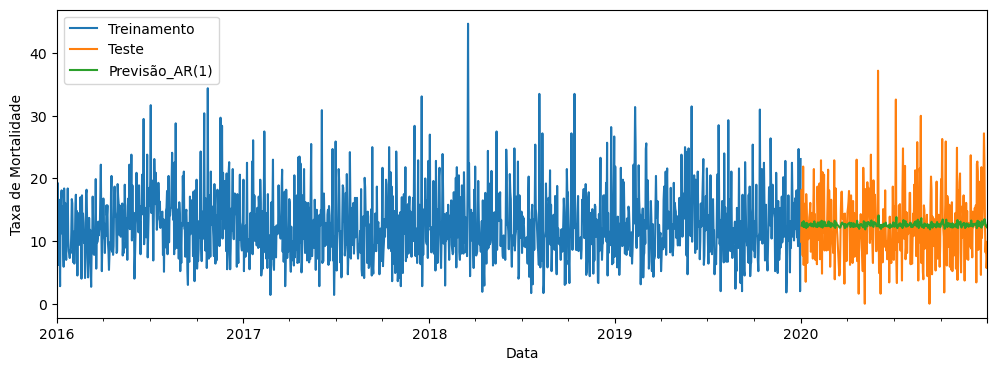

In [123]:
# plotar train/test e previsão
fig, ax = plt.subplots(figsize=(12,4))
train_set.plot()
test_set.plot()
df_test_ar1['previsao'].plot()
ax.legend(['Treinamento','Teste','Previsão_AR(1)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [124]:
# Calcular o erro da previsão
print("Erro do Modelo AR(1):")
print('MSE = ', round(mean_squared_error(df_test_ar1['taxa'], df_test_ar1['previsao']),4))
print('RMSE = ', round(mean_squared_error(df_test_ar1['taxa'], df_test_ar1['previsao'], squared=False),4))
print('MAE = ', round(mean_absolute_error(df_test_ar1['taxa'], df_test_ar1['previsao']),4))

Erro do Modelo AR(1):
MSE =  29.3505
RMSE =  5.4176
MAE =  4.2437


In [125]:
modelo_ar7 = AutoReg(train_set, lags = [7]).fit()
modelo_ar7.params

const      10.526608
taxa.L7     0.166451
dtype: float64

In [126]:
previsao_ar7 = modelo_ar7.params[0] + modelo_ar7.params[1] * test_set.shift(7)

In [127]:
df_test_ar7 = test_set.to_frame()
df_test_ar7['previsao'] = previsao_ar7
df_test_ar7.dropna(inplace=True)
df_test_ar7.head()

,taxa,previsao
data_ocorrencia,,
2020-01-08,8.1,12.174473
2020-01-09,16.0,13.556017
2020-01-10,3.5,12.707116
2020-01-11,17.5,11.808281
2020-01-12,14.4,14.171886


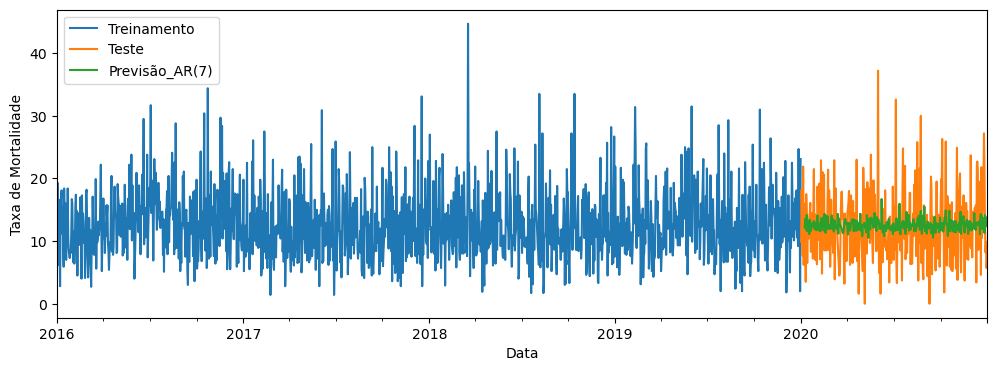

In [128]:
# plotar train/test e previsão
fig, ax = plt.subplots(figsize=(12,4))
train_set.plot()
test_set.plot()
df_test_ar7['previsao'].plot()
ax.legend(['Treinamento','Teste','Previsão_AR(7)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [129]:
# Calcular o erro da previsão
print("Erro do Modelo AR(7):")
print('MSE = ', round(mean_squared_error(df_test_ar7['taxa'], df_test_ar7['previsao']),4))
print('RMSE = ', round(mean_squared_error(df_test_ar7['taxa'], df_test_ar7['previsao'], squared=False),4))
print('MAE = ', round(mean_absolute_error(df_test_ar7['taxa'], df_test_ar7['previsao']),4))

Erro do Modelo AR(7):
MSE =  29.4324
RMSE =  5.4252
MAE =  4.244


In [130]:
modelo_ar14 = AutoReg(train_set, lags = [14]).fit()
modelo_ar14.params

const       10.935813
taxa.L14     0.133901
dtype: float64

In [131]:
previsao_ar14 = modelo_ar14.params[0] + modelo_ar14.params[1] * test_set.shift(14)

In [132]:
df_test_ar14 = test_set.to_frame()
df_test_ar14['previsao'] = previsao_ar14
df_test_ar14.dropna(inplace=True)
df_test_ar14.head()

,taxa,previsao
data_ocorrencia,,
2020-01-15,10.3,12.261437
2020-01-16,12.2,13.372819
2020-01-17,13.8,12.689922
2020-01-18,14.5,11.966854
2020-01-19,16.1,13.868254


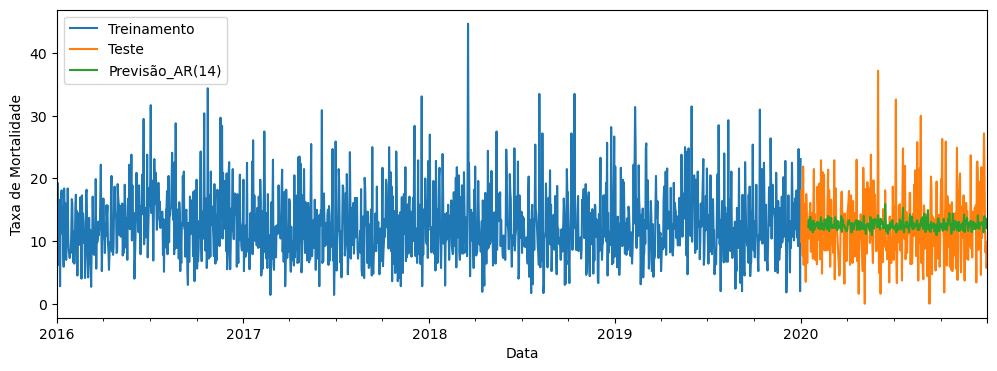

In [133]:
# plotar train/test e previsão
fig, ax = plt.subplots(figsize=(12,4))
train_set.plot()
test_set.plot()
df_test_ar14['previsao'].plot()
ax.legend(['Treinamento','Teste','Previsão_AR(14)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [134]:
# Calcular o erro da previsão
print("Erro do Modelo AR(14):")
print('MSE = ', round(mean_squared_error(df_test_ar14['taxa'], df_test_ar14['previsao']),4))
print('RMSE = ', round(mean_squared_error(df_test_ar14['taxa'], df_test_ar14['previsao'], squared=False),4))
print('MAE = ', round(mean_absolute_error(df_test_ar14['taxa'], df_test_ar14['previsao']),4))

Erro do Modelo AR(14):
MSE =  28.4866
RMSE =  5.3373
MAE =  4.1648


In [135]:
modelo_ar21 = AutoReg(train_set, lags = [21]).fit()
modelo_ar21.params

const       10.778140
taxa.L21     0.146656
dtype: float64

In [136]:
previsao_ar21 = modelo_ar21.params[0] + modelo_ar21.params[1] * test_set.shift(21)

In [137]:
df_test_ar21 = test_set.to_frame()
df_test_ar21['previsao'] = previsao_ar21
df_test_ar21.dropna(inplace=True)
df_test_ar21.head()

,taxa,previsao
data_ocorrencia,,
2020-01-22,11.8,12.230037
2020-01-23,14.5,13.447285
2020-01-24,7.2,12.699337
2020-01-25,15.5,11.907393
2020-01-26,21.5,13.989913


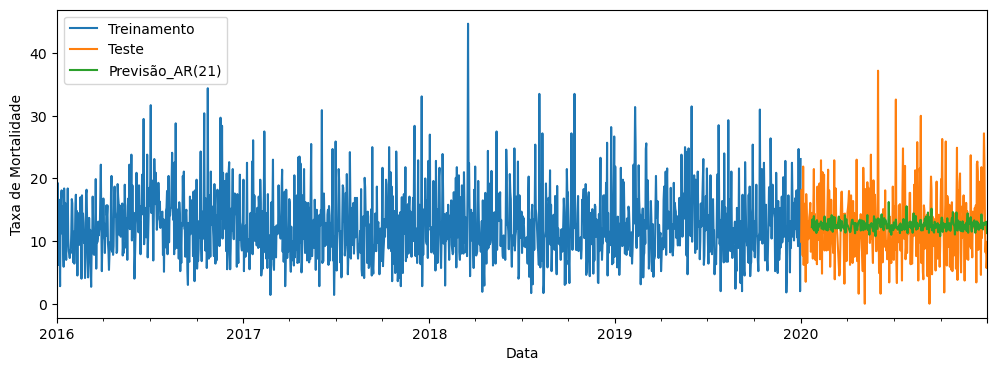

In [138]:
# plotar train/test e previsão
fig, ax = plt.subplots(figsize=(12,4))
train_set.plot()
test_set.plot()
df_test_ar21['previsao'].plot()
plt.legend(['Treinamento','Teste','Previsão_AR(21)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [139]:
# Calcular o erro da previsão
print("Erro do Modelo AR(21):")
print('MSE = ', round(mean_squared_error(df_test_ar21['taxa'], df_test_ar21['previsao']),4))
print('RMSE = ', round(mean_squared_error(df_test_ar21['taxa'], df_test_ar21['previsao'], squared=False),4))
print('MAE = ', round(mean_absolute_error(df_test_ar21['taxa'], df_test_ar21['previsao']),4))

Erro do Modelo AR(21):
MSE =  29.1873
RMSE =  5.4025
MAE =  4.2561


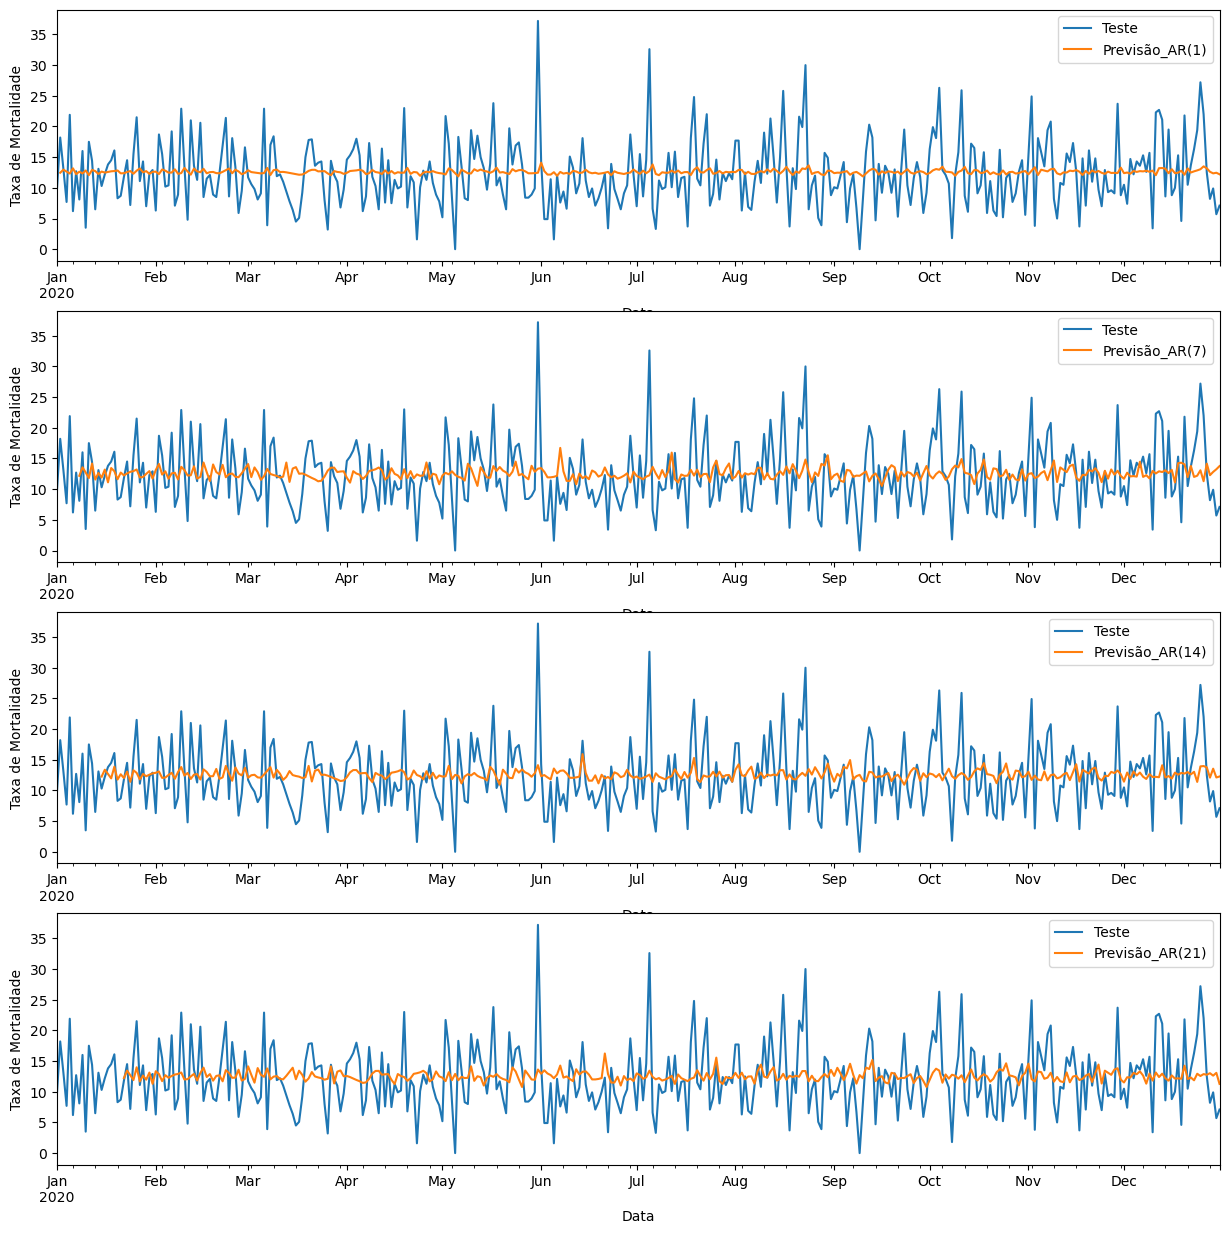

In [140]:
# Comparação test/previsão para os diferentes modelos

fig, axs = plt.subplots(figsize=(15,15)) 

plt.subplot(4,1,1)
test_set.plot()
df_test_ar1['previsao'].plot()
plt.legend(['Teste','Previsão_AR(1)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')

plt.subplot(4,1,2)
test_set.plot()
df_test_ar7['previsao'].plot()
plt.legend(['Teste','Previsão_AR(7)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')

plt.subplot(4,1,3)
test_set.plot()
df_test_ar14['previsao'].plot()
plt.legend(['Teste','Previsão_AR(14)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')

plt.subplot(4,1,4)
test_set.plot()
df_test_ar21['previsao'].plot()
plt.legend(['Teste','Previsão_AR(21)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')

plt.show()

**Comparação dos erros dos diferentes modelos:**


Modelos | MSE     | RMSE   | MAE    |
------- | ------- | ------ | ------ |
AR(1)   | 29.3505 | 5.4176 | 4.2437 |
AR(7)   | 29.4324 | 5.4252 | 4.244  |
AR(14)  | 28.4866 | 5.3373 | 4.1648 |
AR(21)  | 29.1873 | 5.4025 | 4.2561 |

### 5.7. **ARIMA**

O Modelo AutoRegressive Integrated Moving Average (ARIMA) é um modelo generalizado, que combina o modelo AR(p) e o MA(q) para a previsão dos dados (Modelo Auto Regressivo de Média Móvel - ARMA), com uma diferenciação (parâmetro d) para séries não-estacionárias, visto que o ARMA tem utilidade apenas para séries estacionárias. 

O modelo ARIMA é denotado como ARIMA(p, d, q), onde o p é a ordem do modelo auto-regressivo, d é o grau de diferenciação (o número de vezes em que os dados tiveram valores passados subtraídos) e o q é a ordem do modelo de média móvel.

Como a série temporal estudado é estacionária, utilizou-se o ARIMA com o parâmetro d=0, tornando-se equivale ao ARMA(p,q).

O modelo ARMA pode explicar a relação das séries temporais com ruído aleatório (média móvel) e com ele mesmo em uma etapa anterior (auto-regressão).

A partir dos resultados obtidos com o Modelo Auto Regressivo (AR), para o modelo ARMA será utilizado para o parâmetro p, os 2 valores com melhor resultado (p=14 e considerando o MSE, p=21) e comparados com os parâmetros gerados automaticamente.

Para isso, utilizou-se as bibliotecas statsmodels.tsa.arima.model e PMDARIMA e os métodos ARIMA e AutoARIMA, respectivamente.

In [141]:
# Comparando resultado entre os modelos AutoARIMA e o AutoReg
modelo_arma14_0 = ARIMA(train_set, order=(14, 0, 0)).fit()
modelo_arma21_0 = ARIMA(train_set, order=(21, 0, 0)).fit()

# Gerando modelos para q=1
modelo_arma14_1 = ARIMA(train_set, order=(14, 0, 1)).fit()
modelo_arma21_1 = ARIMA(train_set, order=(21, 0, 1)).fit()

# Gerando modelos para q=14
modelo_arma14_14 = ARIMA(train_set, order=(14, 0, 14)).fit()
modelo_arma21_14 = ARIMA(train_set, order=(21, 0, 14)).fit()

# Gerando modelos para q=21
modelo_arma14_21 = ARIMA(train_set, order=(14, 0, 21)).fit()
modelo_arma21_21 = ARIMA(train_set, order=(21, 0, 21)).fit()

In [142]:
# Aplicando os modelos com os dados de testes

test_arma14_0 = ARIMA(test_set, order=(14, 0, 0)).fit(modelo_arma14_0.params)
test_arma21_0 = ARIMA(test_set, order=(21, 0, 0)).fit(modelo_arma21_0.params)

test_arma14_1 = ARIMA(test_set, order=(14, 0, 1)).fit(modelo_arma14_1.params)
test_arma21_1 = ARIMA(test_set, order=(21, 0, 1)).fit(modelo_arma21_1.params)

test_arma14_14 = ARIMA(test_set, order=(14, 0, 14)).fit(modelo_arma14_14.params)
test_arma21_14 = ARIMA(test_set, order=(21, 0, 14)).fit(modelo_arma21_14.params)

test_arma14_21 = ARIMA(test_set, order=(14, 0, 21)).fit(modelo_arma14_21.params)
test_arma21_21 = ARIMA(test_set, order=(21, 0, 21)).fit(modelo_arma21_21.params)

In [143]:
# Aplicando o auto_arima para encontrar os parâmetros
model_auto_arima = auto_arima(train_set)
model_auto_arima.order

(0, 0, 1)

In [144]:
# Gerando as previsões

previsao_arma14_0 = test_arma14_0.predict()
previsao_arma21_0 = test_arma21_0.predict()
previsao_arma14_1 = test_arma14_1.predict()
previsao_arma21_1 = test_arma21_1.predict()
previsao_arma14_14 = test_arma14_14.predict()
previsao_arma21_14 = test_arma21_14.predict()
previsao_arma14_21 = test_arma14_21.predict()
previsao_arma21_21 = test_arma21_21.predict()

previsao_autoarima = model_auto_arima.predict(n_periods=len(test_set))

In [145]:
# Gerando dataframe com todas as previsões
df_test_arma = test_set.to_frame()
df_test_arma['previsao_arma14_0'] = previsao_arma14_0
df_test_arma['previsao_arma21_0'] = previsao_arma21_0
df_test_arma['previsao_arma14_1'] = previsao_arma14_1
df_test_arma['previsao_arma21_1'] = previsao_arma21_1
df_test_arma['previsao_arma14_14'] = previsao_arma14_14
df_test_arma['previsao_arma21_14'] = previsao_arma21_14
df_test_arma['previsao_arma14_21'] = previsao_arma14_21
df_test_arma['previsao_arma21_21'] = previsao_arma21_21
df_test_arma['previsao_autoarima'] = previsao_autoarima
df_test_arma.head()

,taxa,previsao_arma14_0,previsao_arma21_0,previsao_arma14_1,previsao_arma21_1,previsao_arma14_14,previsao_arma21_14,previsao_arma14_21,previsao_arma21_21,previsao_autoarima
data_ocorrencia,,,,,,,,,,
2020-01-01,9.9,12.273290,12.255989,12.272824,12.252248,12.488244,12.524118,12.534768,12.500719,13.301338
2020-01-02,18.2,12.187313,12.170058,12.187138,12.171044,12.469132,12.407162,12.431279,12.399217,12.622098
2020-01-03,13.1,12.732271,12.711679,12.730970,12.692875,12.780638,12.980145,12.931096,12.939329,12.622098
2020-01-04,7.7,11.699100,11.693781,11.698987,11.694358,12.079834,12.069123,12.080180,12.143280,12.622098
2020-01-05,21.9,12.281436,12.258337,12.280754,12.259930,12.273462,12.561515,12.683114,12.321400,12.622098


In [146]:
print("MSE do Modelo ARIMA:")
print('Arma14_0 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_0']),4))
print('Arma21_0 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_0']),4))
print('Arma14_1 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_1']),4))
print('Arma21_1 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_1']),4))
print('Arma14_14 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_14']),4))
print('Arma21_14 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_14']),4))
print('Arma14_21 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_21']),4))
print('Arma21_21 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_21']),4))
print('Autoarima = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_autoarima']),4))

MSE do Modelo ARIMA:
Arma14_0 =  27.2288
Arma21_0 =  26.1676
Arma14_1 =  27.2242
Arma21_1 =  26.0622
Arma14_14 =  24.4647
Arma21_14 =  23.7954
Arma14_21 =  23.7668
Arma21_21 =  23.2934
Autoarima =  29.3382


In [147]:
print("RMSE do Modelo ARIMA:")
print('Arma14_0 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_0'], squared=False),4))
print('Arma21_0 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_0'], squared=False),4))
print('Arma14_1 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_1'], squared=False),4))
print('Arma21_1 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_1'], squared=False),4))
print('Arma14_14 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_14'], squared=False),4))
print('Arma21_14 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_14'], squared=False),4))
print('Arma14_21 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_21'], squared=False),4))
print('Arma21_21 = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_21'], squared=False),4))
print('Autoarima = ', round(mean_squared_error(df_test_arma['taxa'], df_test_arma['previsao_autoarima'], squared=False),4))

RMSE do Modelo ARIMA:
Arma14_0 =  5.2181
Arma21_0 =  5.1154
Arma14_1 =  5.2177
Arma21_1 =  5.1051
Arma14_14 =  4.9462
Arma21_14 =  4.878
Arma14_21 =  4.8751
Arma21_21 =  4.8263
Autoarima =  5.4165


In [148]:
print("MAE do Modelo ARIMA:")
print('Arma14_0 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_0']),4))
print('Arma21_0 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_0']),4))
print('Arma14_1 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_1']),4))
print('Arma21_1 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_1']),4))
print('Arma14_14 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_14']),4))
print('Arma21_14 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_14']),4))
print('Arma14_21 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma14_21']),4))
print('Arma21_21 = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_arma21_21']),4))
print('Autoarima = ', round(mean_absolute_error(df_test_arma['taxa'], df_test_arma['previsao_autoarima']),4))

MAE do Modelo ARIMA:
Arma14_0 =  4.0498
Arma21_0 =  3.9746
Arma14_1 =  4.0489
Arma21_1 =  3.9497
Arma14_14 =  3.8673
Arma21_14 =  3.8651
Arma14_21 =  3.8396
Arma21_21 =  3.8069
Autoarima =  4.2508


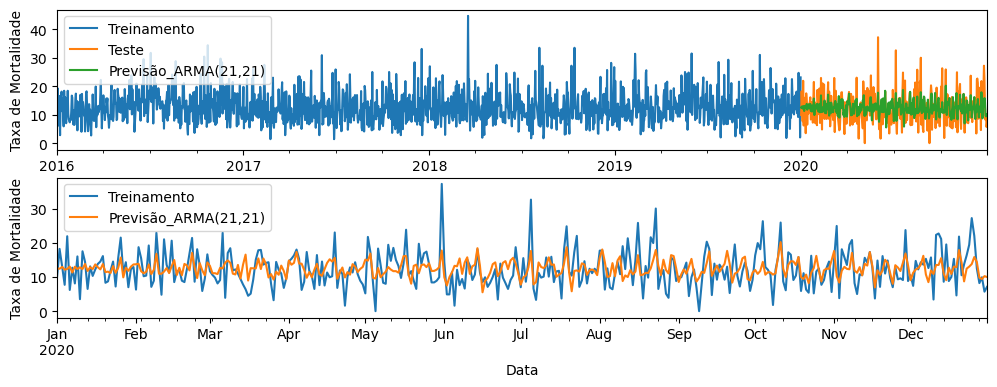

In [149]:
# plotar train/test e previsão do modelo com menor erro
fig, ax = plt.subplots(figsize=(12,4))

plt.subplot(2,1,1)
train_set.plot()
test_set.plot()
df_test_arma['previsao_arma21_21'].plot()
plt.legend(['Treinamento','Teste','Previsão_ARMA(21,21)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')

plt.subplot(2,1,2)
test_set.plot()
df_test_arma['previsao_arma21_21'].plot()
plt.legend(['Treinamento','Previsão_ARMA(21,21)'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')

plt.show()

Os modelos ARIMA tiveram um melhor desempenho quando comparados com os AR, o que já era esperado, visto que esse modelo além da componente auto-regressiva, possui o ajuste dos erros residuais.
O modelo auto_arima foi o que teve o pior resultado quando comparado aos diferentes modelos do ARIMA, porém o resultado foi ligeiramente melhor quando comparado com o AR para 1 lag e 7 lags.

### 5.8. **Árvore de Decisão para Regressão**

Foi realizada uma rápida aplicação do algoritmo DecisionTreeRegressor (modelo regressivo baseado em árvore de decisão), para verificar se existe um possível cenário com erro menor dos encontrados até aqui.

Para aplicar um modelo preditivo com variáveis exógenas, precisamos definir primeiro as variáveis endógenas. Para uma série temporal, as variáveis endógenas são os valores anteriores ao período alvo. Definimos o número de variáveis endógenas como o número de *lags p*.

In [150]:
# Após algumas simulações (com 1 <= p <= 21, seguindo as análises realizadas até aqui), 
# verificou-se que p=21 apresentou o melhor resultado para esse modelo.

p = 21

df = pd.DataFrame.copy(df_diario)
for i in range(p):
        df[f'x{i + 1}'] = df.taxa.shift(i + 1)
df.dropna(axis=0, inplace=True)

In [151]:
X = df.drop('taxa', axis=1)
y = df.taxa

trainAD_size = int(len(X)*0.8)
X_train = X[:trainAD_size]
X_test = X[trainAD_size:]
y_train = y[:trainAD_size]
y_test = y[trainAD_size:]

In [152]:
# Após algumas simulações, verificou-se que max_depth = 2 apresentou melhor resultado para o método.

max_depth = 2

reg = DecisionTreeRegressor(max_depth=max_depth)
model_reg = reg.fit(X_train,y_train)
previsaoAD = model_reg.predict(X_test)
df_test_AD = X_test.copy()
df_test_AD['taxa'] = y_test

# Gerando a previsão
previsao_AD = model_reg.predict(X_test)
df_test_AD['previsão'] = previsao_AD

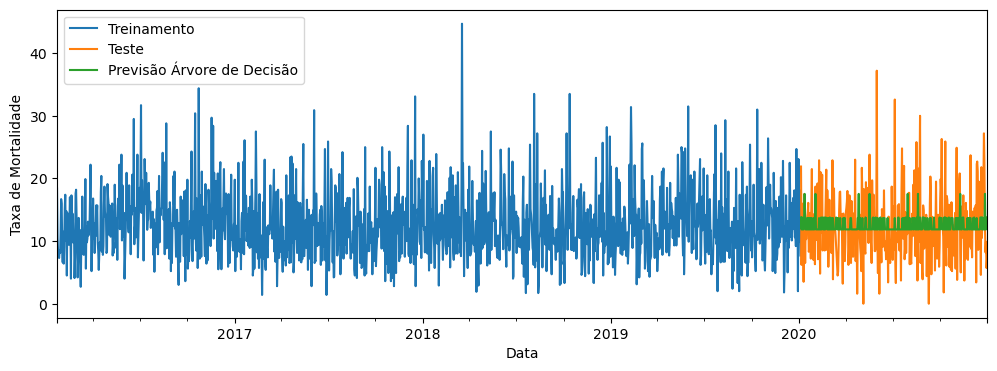

In [153]:
# plotar train/test e previsão.

fig, ax = plt.subplots(figsize=(12,4))
y_train.plot()
y_test.plot()
df_test_AD['previsão'].plot()
plt.legend(['Treinamento','Teste','Previsão Árvore de Decisão'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

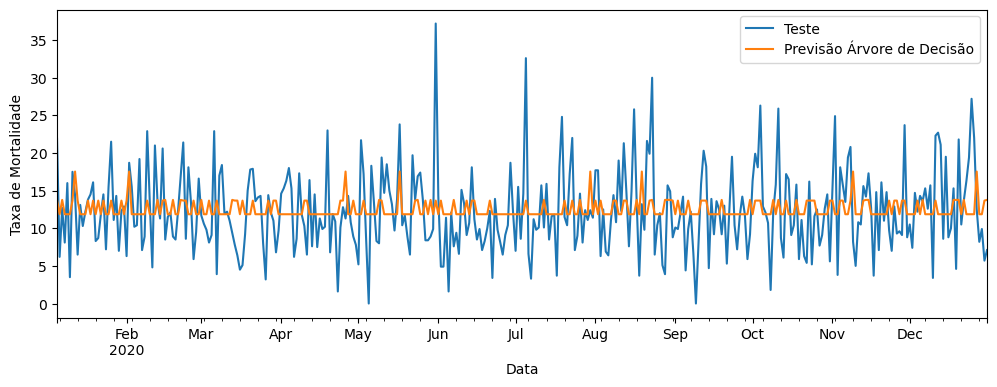

In [154]:
# plotar test e previsão.

fig, ax = plt.subplots(figsize=(12,4))
y_test.plot()
df_test_AD['previsão'].plot()
plt.legend(['Teste','Previsão Árvore de Decisão'])
plt.xlabel('Data')
plt.ylabel('Taxa de Mortalidade')
plt.show()

In [155]:
# Calcular o erro da previsão
print("Erro do Modelo Árvore de Decisão para Regressão:")
print('MSE = ', round(mean_squared_error(y_test, previsao_AD),4))
print('RMSE = ', round(mean_squared_error(y_test, previsao_AD, squared=False),4))
print('MAE = ', round(mean_absolute_error(y_test, previsao_AD),4))

Erro do Modelo Árvore de Decisão para Regressão:
MSE =  28.6123
RMSE =  5.349
MAE =  4.1985
